In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, HTML

#Stop showing warnings
pd.options.mode.chained_assignment = None  
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Statistical packages
from statsmodels.stats.power import TTestIndPower,TTestPower #Power calculation

from scipy.stats import mannwhitneyu,iqr #Mann-Whitney U test

import time
start=time.time()

#### Caution: Indices must be set appropriately in many cells below for each of the emphysema/non-emphysema groups

In [2]:
#Read excel files with data
mod=pd.read_excel(os.getcwd()+"\\moderate_manual.xlsx")
conf=pd.read_excel(os.getcwd()+"\\moderate_manual.xlsx")
adv=pd.read_excel(os.getcwd()+"\\advanced_manual.xlsx")
noemph=pd.read_excel(os.getcwd()+"\\noemphysema_manual.xlsx")

## Function to add metric values to df

In [3]:
#Weights used not take into account the number of nodules per patient
#These are taken into account in the denominator of most metrics (usually a weighted sum of tp+fn+fp)

#In 'my_metric' when FP>0 and TP=FN=0 value always 0! If 1FP and eg. 5FN always 1=> adapt accordingly (see other metrics)
#Some metrics with less weight in FP since in no-emphysema cases many more scans and maybe many more FPs
#In the last scenario, we will probably also have more TPs and FNs in no-emphysema, so maybe not important

#Not all metrics below used in paper - Also metrics for nodules >300mm3 were not used
#0_100 refers to group 30_100 since we didn't not take into account nodules <30mm3

#Some metrics cannot be calculated when TP=FN=0 and that's why we need 'no_nods' parameter below.
#In that case, '0_100' group includes all nodules, of all sizes - All being FPs.

def metric_create(list_of_strings_with_df,b=1,no_nods=False):
    #Metric choices:
    #1) 'my_metric': (fp+b^2*fn)/((1+b^2)tp+fp+b^2*fn) #closest to 1 the worst the performance = 1-Fbscore
    #2) 'no_weights': (fp+fn)/(fp+fn+tp)
    #3) 'fully_weighted': (afp+c(b^2)fn)/(fp+(b^2)fn+(1+b^2)tp where a=0.1fp, and c=0.75 when FN=1,
    # 0.85 when FN=2 and 1 when FN>2
    #4) 'fb_score': (1+b^2)tp/((1+b^2)tp+(b^2)fn+fp)
    #5) 'precision': tp/(tp+fp)
    #6) 'recall': tp/(tp+fn)
    #7) 'False negative rate (FNR): fn/(fn+tp)'
    #8) 'False discovery rate (FDR): fp/(fp+tp)'
    #9) 'Fowlkes_mallows_index (FM): sqrt(tp*tp/((tp+fp)*(tp+fn)))'
    #10) 'Threat score - Critical success index - Jaccard_index (JI): tp/(tp+fn+fp)'
    #REMARK: no_weights=1-JI!
    
    #11) 'fp_all': fp/(fp+tp+fn)
    #12) 'tp_all': tp/(fp+tp+fn)
    #13) 'fn_all': fn/(fp+tp+fn)
    
    #More metrics in https://en.wikipedia.org/wiki/Sensitivity_and_specificity
    
    'Gets a list of strings with the names of dataframes containing different nodule sizes for a specific degree.'
    'It also gets an optional value <b> which is the weight used for FNs,'
    'and a parameter <no_nods> to identify the non-nodule group from the volume subgroups'
    
    a=1+b**2 #According to the definition of Fb score
    
    for size in list_of_strings_with_df: #Loop over unique size names of given emphysema type/non-emphysema

        #Add zeros in columns with TP,FP and FN that currently have nans
        if no_nods==True:
            eval(size)[['100-300fp','100-300fn','100-300tp','300+ fp','300+ fn','300+ tp']]=0
            
        eval(size)[['0-100fp', '0-100fn','0-100tp','100-300fp','100-300fn','100-300tp','300+ fp','300+ fn','300+ tp']] = eval(size)[['0-100fp', '0-100fn','0-100tp','100-300fp','100-300fn','100-300tp','300+ fp','300+ fn','300+ tp']].fillna(value=0)
        
        #Create columns with metric values for each size group (set to float type 0s)
        eval(size)['mymetric_0_100']=0
        eval(size)['mymetric_0_100']=eval(size)['mymetric_0_100'].astype(float)

        eval(size)['mymetric_100_300']=0
        eval(size)['mymetric_100_300']=eval(size)['mymetric_100_300'].astype(float)

        #Sizes 300+ will not be used in manuscript
        eval(size)['mymetric_300']=0
        eval(size)['mymetric_300']=eval(size)['mymetric_300'].astype(float)

        #Similarly for other metrics      
        eval(size)['no_weights_0_100']=0
        eval(size)['no_weights_0_100']=eval(size)['no_weights_0_100'].astype(float)
        eval(size)['no_weights_100_300']=0
        eval(size)['no_weights_100_300']=eval(size)['no_weights_100_300'].astype(float)
        eval(size)['no_weights_300']=0
        eval(size)['no_weights_300']=eval(size)['no_weights_300'].astype(float)        

        eval(size)['fully_weighted_0_100']=0
        eval(size)['fully_weighted_0_100']=eval(size)['fully_weighted_0_100'].astype(float)
        eval(size)['fully_weighted_100_300']=0
        eval(size)['fully_weighted_100_300']=eval(size)['fully_weighted_100_300'].astype(float)
        eval(size)['fully_weighted_300']=0
        eval(size)['fully_weighted_300']=eval(size)['fully_weighted_300'].astype(float)
        
        #Here set to 1 which is the 'best' value for this metric
        eval(size)['fb_score_0_100']=1
        eval(size)['fb_score_0_100']=eval(size)['fb_score_0_100'].astype(float)
        eval(size)['fb_score_100_300']=1
        eval(size)['fb_score_100_300']=eval(size)['fb_score_100_300'].astype(float)
        eval(size)['fb_score_300']=1
        eval(size)['fb_score_300']=eval(size)['fb_score_300'].astype(float)
        
        eval(size)['precision_0_100']=1
        eval(size)['precision_0_100']=eval(size)['precision_0_100'].astype(float)
        eval(size)['precision_100_300']=1
        eval(size)['precision_100_300']=eval(size)['precision_100_300'].astype(float)
        eval(size)['precision_300']=1
        eval(size)['precision_300']=eval(size)['precision_300'].astype(float)
        
        eval(size)['fp_all_0_100']=0
        eval(size)['fp_all_0_100']=eval(size)['fp_all_0_100'].astype(float)
        eval(size)['fp_all_100_300']=0
        eval(size)['fp_all_100_300']=eval(size)['fp_all_100_300'].astype(float)
        eval(size)['fp_all_300']=0
        eval(size)['fp_all_300']=eval(size)['fp_all_300'].astype(float)

        eval(size)['tp_all_0_100']=0
        eval(size)['tp_all_0_100']=eval(size)['tp_all_0_100'].astype(float)
        eval(size)['tp_all_100_300']=0
        eval(size)['tp_all_100_300']=eval(size)['tp_all_100_300'].astype(float)
        eval(size)['tp_all_300']=0
        eval(size)['tp_all_300']=eval(size)['tp_all_300'].astype(float)
        
        eval(size)['fn_all_0_100']=0
        eval(size)['fn_all_0_100']=eval(size)['fn_all_0_100'].astype(float)
        eval(size)['fn_all_100_300']=0
        eval(size)['fn_all_100_300']=eval(size)['fn_all_100_300'].astype(float)
        eval(size)['fn_all_300']=0
        eval(size)['fn_all_300']=eval(size)['fn_all_300'].astype(float)
        
        #For individuals without nodules we may not even need all the metrics above. 
        #Maybe keep only FP or 'fully_weighted' for them
        
        if no_nods==False: #If we want individuals without nodules, the following metrics will be ignored
            eval(size)['recall_0_100']=1
            eval(size)['recall_0_100']=eval(size)['recall_0_100'].astype(float)
            eval(size)['recall_100_300']=1
            eval(size)['recall_100_300']=eval(size)['recall_100_300'].astype(float)
            eval(size)['recall_300']=1
            eval(size)['recall_300']=eval(size)['recall_300'].astype(float)

            eval(size)['FNR_0_100']=0
            eval(size)['FNR_0_100']=eval(size)['FNR_0_100'].astype(float)
            eval(size)['FNR_100_300']=0
            eval(size)['FNR_100_300']=eval(size)['FNR_100_300'].astype(float)
            eval(size)['FNR_300']=0
            eval(size)['FNR_300']=eval(size)['FNR_300'].astype(float)

            eval(size)['FM_0_100']=1
            eval(size)['FM_0_100']=eval(size)['FM_0_100'].astype(float)
            eval(size)['FM_100_300']=1
            eval(size)['FM_100_300']=eval(size)['FM_100_300'].astype(float)
            eval(size)['FM_300']=1
            eval(size)['FM_300']=eval(size)['FM_300'].astype(float)
        
        eval(size)['FDR_0_100']=0
        eval(size)['FDR_0_100']=eval(size)['FDR_0_100'].astype(float)
        eval(size)['FDR_100_300']=0
        eval(size)['FDR_100_300']=eval(size)['FDR_100_300'].astype(float)
        eval(size)['FDR_300']=0
        eval(size)['FDR_300']=eval(size)['FDR_300'].astype(float)
        
        eval(size)['JI_0_100']=1
        eval(size)['JI_0_100']=eval(size)['JI_0_100'].astype(float)
        eval(size)['JI_100_300']=1
        eval(size)['JI_100_300']=eval(size)['JI_100_300'].astype(float)
        eval(size)['JI_300']=1
        eval(size)['JI_300']=eval(size)['JI_300'].astype(float)
        
        
        for i in range(len(eval(size))): #Loop over size of each dataframe

            #If we don't have nodules and AI does not detect nodules then performance is perfect (0)
            if eval(size)['0-100fp'].iloc[i]==0 and eval(size)['0-100fn'].iloc[i]==0 and eval(size)['0-100tp'].iloc[i]==0:
                pass
            else: #Set metric value according to formula in https://en.wikipedia.org/wiki/F-score
                eval(size)['mymetric_0_100'].iloc[i]=(eval(size)['0-100fp'].iloc[i]+(b**2)*eval(size)['0-100fn'].iloc[i])/(a*eval(size)['0-100tp'].iloc[i]+eval(size)['0-100fp'].iloc[i]+(b**2)*eval(size)['0-100fn'].iloc[i])
                eval(size)['fp_all_0_100'].iloc[i]=eval(size)['0-100fp'].iloc[i]/(eval(size)['0-100fp'].iloc[i]+eval(size)['0-100fn'].iloc[i]+eval(size)['0-100tp'].iloc[i])
                eval(size)['tp_all_0_100'].iloc[i]=eval(size)['0-100tp'].iloc[i]/(eval(size)['0-100fp'].iloc[i]+eval(size)['0-100fn'].iloc[i]+eval(size)['0-100tp'].iloc[i])
                eval(size)['fn_all_0_100'].iloc[i]=eval(size)['0-100fn'].iloc[i]/(eval(size)['0-100fp'].iloc[i]+eval(size)['0-100fn'].iloc[i]+eval(size)['0-100tp'].iloc[i])

            #Similar for other sizes
            if eval(size)['100-300fp'].iloc[i]==0 and eval(size)['100-300fn'].iloc[i]==0 and eval(size)['100-300tp'].iloc[i]==0:
                pass
            else:
                eval(size)['mymetric_100_300'].iloc[i]=(eval(size)['100-300fp'].iloc[i]+(b**2)*eval(size)['100-300fn'].iloc[i])/(a*eval(size)['100-300tp'].iloc[i]+eval(size)['100-300fp'].iloc[i]+(b**2)*eval(size)['100-300fn'].iloc[i])
                eval(size)['fp_all_100_300'].iloc[i]=eval(size)['100-300fp'].iloc[i]/(eval(size)['100-300fp'].iloc[i]+eval(size)['100-300fn'].iloc[i]+eval(size)['100-300tp'].iloc[i])
                eval(size)['tp_all_100_300'].iloc[i]=eval(size)['100-300tp'].iloc[i]/(eval(size)['100-300fp'].iloc[i]+eval(size)['100-300fn'].iloc[i]+eval(size)['100-300tp'].iloc[i])
                eval(size)['fn_all_100_300'].iloc[i]=eval(size)['100-300fn'].iloc[i]/(eval(size)['100-300fp'].iloc[i]+eval(size)['100-300fn'].iloc[i]+eval(size)['100-300tp'].iloc[i])

            if eval(size)['300+ fp'].iloc[i]==0 and eval(size)['300+ fn'].iloc[i]==0 and eval(size)['300+ tp'].iloc[i]==0:
                pass
            else:
                eval(size)['mymetric_300'].iloc[i]=(eval(size)['300+ fp'].iloc[i]+(b**2)*eval(size)['300+ fn'].iloc[i])/(a*eval(size)['300+ tp'].iloc[i]+eval(size)['300+ fp'].iloc[i]+(b**2)*eval(size)['300+ fn'].iloc[i])  
                eval(size)['fp_all_300'].iloc[i]=eval(size)['300+ fp'].iloc[i]/(eval(size)['300+ fp'].iloc[i]+eval(size)['300+ fn'].iloc[i]+eval(size)['300+ tp'].iloc[i])
                eval(size)['tp_all_300'].iloc[i]=eval(size)['300+ tp'].iloc[i]/(eval(size)['300+ fp'].iloc[i]+eval(size)['300+ fn'].iloc[i]+eval(size)['300+ tp'].iloc[i])
                eval(size)['fn_all_300'].iloc[i]=eval(size)['300+ fn'].iloc[i]/(eval(size)['300+ fp'].iloc[i]+eval(size)['300+ fn'].iloc[i]+eval(size)['300+ tp'].iloc[i])


            #For the rest metrics
            
            if eval(size)['0-100fp'].iloc[i]==0 and eval(size)['0-100fn'].iloc[i]==0 and eval(size)['0-100tp'].iloc[i]==0:
                pass
            else: 
                #Define weights based on num of FPs and FNs
                if eval(size)['0-100fp'].iloc[i]<10:
                    a1=0.1*eval(size)['0-100fp'].iloc[i]
                else:
                    a1=1
                    
                if eval(size)['0-100fn'].iloc[i]==1:
                    c1=0.75
                elif eval(size)['0-100fn'].iloc[i]==2:
                    c1=0.85
                else:
                    c1=1
                    
                eval(size)['no_weights_0_100'].iloc[i]=(eval(size)['0-100fp'].iloc[i]+eval(size)['0-100fn'].iloc[i])/(eval(size)['0-100tp'].iloc[i]+eval(size)['0-100fp'].iloc[i]+eval(size)['0-100fn'].iloc[i])                    
                eval(size)['fully_weighted_0_100'].iloc[i]=(a1*eval(size)['0-100fp'].iloc[i]+c1*(b**2)*eval(size)['0-100fn'].iloc[i])/(a*eval(size)['0-100tp'].iloc[i]+eval(size)['0-100fp'].iloc[i]+(b**2)*eval(size)['0-100fn'].iloc[i])
                eval(size)['fb_score_0_100'].iloc[i]=((1+b**2)*eval(size)['0-100tp'].iloc[i])/((1+b**2)*eval(size)['0-100tp'].iloc[i]+eval(size)['0-100fp'].iloc[i]+(b**2)*eval(size)['0-100fn'].iloc[i])
                eval(size)['JI_0_100'].iloc[i]=(eval(size)['0-100tp'].iloc[i])/(eval(size)['0-100tp'].iloc[i]+eval(size)['0-100fp'].iloc[i]+eval(size)['0-100fn'].iloc[i])

            #Similar for other sizes
            if eval(size)['100-300fp'].iloc[i]==0 and eval(size)['100-300fn'].iloc[i]==0 and eval(size)['100-300tp'].iloc[i]==0:
                pass
            else:
                
                if eval(size)['100-300fp'].iloc[i]<10:
                    a1=0.1*eval(size)['100-300fp'].iloc[i]
                else:
                    a1=1
                    
                if eval(size)['100-300fn'].iloc[i]==1:
                    c1=0.75
                elif eval(size)['100-300fn'].iloc[i]==2:
                    c1=0.85
                else:
                    c1=1
                    
                eval(size)['no_weights_100_300'].iloc[i]=(eval(size)['100-300fp'].iloc[i]+eval(size)['100-300fn'].iloc[i])/(eval(size)['100-300tp'].iloc[i]+eval(size)['100-300fp'].iloc[i]+eval(size)['100-300fn'].iloc[i])
                eval(size)['fully_weighted_100_300'].iloc[i]=(a1*eval(size)['100-300fp'].iloc[i]+c1*(b**2)*eval(size)['100-300fn'].iloc[i])/(a*eval(size)['100-300tp'].iloc[i]+eval(size)['100-300fp'].iloc[i]+(b**2)*eval(size)['100-300fn'].iloc[i])
                eval(size)['fb_score_100_300'].iloc[i]=((1+b**2)*eval(size)['100-300tp'].iloc[i])/((1+b**2)*eval(size)['100-300tp'].iloc[i]+eval(size)['100-300fp'].iloc[i]+(b**2)*eval(size)['100-300fn'].iloc[i])
                eval(size)['JI_100_300'].iloc[i]=(eval(size)['100-300tp'].iloc[i])/(eval(size)['100-300tp'].iloc[i]+eval(size)['100-300fp'].iloc[i]+eval(size)['100-300fn'].iloc[i])
            
            if eval(size)['300+ fp'].iloc[i]==0 and eval(size)['300+ fn'].iloc[i]==0 and eval(size)['300+ tp'].iloc[i]==0:
                pass
            else:
                
                if eval(size)['300+ fp'].iloc[i]<10:
                    a1=0.1*eval(size)['300+ fp'].iloc[i]
                else:
                    a1=1
                    
                if eval(size)['300+ fn'].iloc[i]==1:
                    c1=0.75
                elif eval(size)['300+ fn'].iloc[i]==2:
                    c1=0.85
                else:
                    c1=1
                                    
                eval(size)['no_weights_300'].iloc[i]=(eval(size)['300+ fp'].iloc[i]+eval(size)['300+ fn'].iloc[i])/(eval(size)['300+ tp'].iloc[i]+eval(size)['300+ fp'].iloc[i]+eval(size)['300+ fn'].iloc[i])
                eval(size)['fully_weighted_300'].iloc[i]=(a1*eval(size)['300+ fp'].iloc[i]+c1*(b**2)*eval(size)['300+ fn'].iloc[i])/(a*eval(size)['300+ tp'].iloc[i]+eval(size)['300+ fp'].iloc[i]+(b**2)*eval(size)['300+ fn'].iloc[i])
                eval(size)['fb_score_300'].iloc[i]=((1+b**2)*eval(size)['300+ tp'].iloc[i])/((1+b**2)*eval(size)['300+ tp'].iloc[i]+eval(size)['300+ fp'].iloc[i]+(b**2)*eval(size)['300+ fn'].iloc[i])
                eval(size)['JI_300'].iloc[i]=(eval(size)['300+ tp'].iloc[i])/(eval(size)['300+ tp'].iloc[i]+eval(size)['300+ fp'].iloc[i]+eval(size)['300+ fn'].iloc[i])
            
            #Precision, Recall and FM
            #https://stats.stackexchange.com/questions/8025/what-are-correct-values-for-precision-and-recall-when-the-denominators-equal-0
            if eval(size)['0-100tp'].iloc[i]==0:
                if no_nods==False:
                    if eval(size)['0-100fn'].iloc[i]==0:
                        eval(size)['recall_0_100'].iloc[i]=np.nan
                    else:
                        eval(size)['recall_0_100'].iloc[i]=0
                    
                if eval(size)['0-100fp'].iloc[i]==0:
                    eval(size)['precision_0_100'].iloc[i]=np.nan
                else:
                    eval(size)['precision_0_100'].iloc[i]=0
                 
                if no_nods==False:
                    if eval(size)['0-100fn'].iloc[i]==0 or eval(size)['0-100fp'].iloc[i]==0:
                        eval(size)['FM_0_100'].iloc[i]=np.nan
                    else:
                        eval(size)['FM_0_100'].iloc[i]=0
                    
                    
            else:
                eval(size)['precision_0_100'].iloc[i]=eval(size)['0-100tp'].iloc[i]/(eval(size)['0-100tp'].iloc[i]+eval(size)['0-100fp'].iloc[i])
                
                if no_nods==False:
                    eval(size)['recall_0_100'].iloc[i]=eval(size)['0-100tp'].iloc[i]/(eval(size)['0-100tp'].iloc[i]+eval(size)['0-100fn'].iloc[i])
                    eval(size)['FM_0_100'].iloc[i]=np.sqrt((eval(size)['0-100tp'].iloc[i]*eval(size)['0-100tp'].iloc[i])/((eval(size)['0-100tp'].iloc[i]+eval(size)['0-100fp'].iloc[i])*(eval(size)['0-100fn'].iloc[i]+eval(size)['0-100tp'].iloc[i])))

                
            if eval(size)['100-300tp'].iloc[i]==0:
                if no_nods==False:
                    if eval(size)['100-300fn'].iloc[i]==0:
                        eval(size)['recall_100_300'].iloc[i]=np.nan
                    else:
                        eval(size)['recall_100_300'].iloc[i]=0                

                if eval(size)['100-300fp'].iloc[i]==0:
                    eval(size)['precision_100_300'].iloc[i]=np.nan
                else:
                    eval(size)['precision_100_300'].iloc[i]=0
                
                if no_nods==False:
                    if eval(size)['100-300fn'].iloc[i]==0 or eval(size)['100-300fp'].iloc[i]==0:
                        eval(size)['FM_100_300'].iloc[i]=np.nan
                    else:
                        eval(size)['FM_100_300'].iloc[i]=0
                    
            else:
                eval(size)['precision_100_300'].iloc[i]=eval(size)['100-300tp'].iloc[i]/(eval(size)['100-300tp'].iloc[i]+eval(size)['100-300fp'].iloc[i])
                
                if no_nods==False:
                    eval(size)['recall_100_300'].iloc[i]=eval(size)['100-300tp'].iloc[i]/(eval(size)['100-300tp'].iloc[i]+eval(size)['100-300fn'].iloc[i])
                    eval(size)['FM_100_300'].iloc[i]=np.sqrt((eval(size)['100-300tp'].iloc[i]*eval(size)['100-300tp'].iloc[i])/((eval(size)['100-300tp'].iloc[i]+eval(size)['100-300fp'].iloc[i])*(eval(size)['100-300fn'].iloc[i]+eval(size)['100-300tp'].iloc[i])))

                    
            if eval(size)['300+ tp'].iloc[i]==0:
                if no_nods==False:
                    if eval(size)['300+ fn'].iloc[i]==0:
                        eval(size)['recall_300'].iloc[i]=np.nan
                    else:
                        eval(size)['recall_300'].iloc[i]=0                

                if eval(size)['300+ fp'].iloc[i]==0:
                    eval(size)['precision_300'].iloc[i]=np.nan
                else:
                    eval(size)['precision_300'].iloc[i]=0
                 
                if no_nods==False:
                    if eval(size)['300+ fn'].iloc[i]==0 or eval(size)['300+ fp'].iloc[i]==0:
                        eval(size)['FM_300'].iloc[i]=np.nan
                    else:
                        eval(size)['FM_300'].iloc[i]=0
                    
            else:
                eval(size)['precision_300'].iloc[i]=eval(size)['300+ tp'].iloc[i]/(eval(size)['300+ tp'].iloc[i]+eval(size)['300+ fp'].iloc[i])
                
                if no_nods==False:
                    eval(size)['recall_300'].iloc[i]=eval(size)['300+ tp'].iloc[i]/(eval(size)['300+ tp'].iloc[i]+eval(size)['300+ fn'].iloc[i])          
                    eval(size)['FM_300'].iloc[i]=np.sqrt((eval(size)['300+ tp'].iloc[i]*eval(size)['300+ tp'].iloc[i])/((eval(size)['300+ tp'].iloc[i]+eval(size)['300+ fp'].iloc[i])*(eval(size)['300+ fn'].iloc[i]+eval(size)['300+ tp'].iloc[i])))
                
            #False negative rate and false discovery rate
            if no_nods==False:
                if eval(size)['0-100fn'].iloc[i]==0:
                    if eval(size)['0-100tp'].iloc[i]==0: #else not needed since already set to 0 in that case
                        eval(size)['FNR_0_100'].iloc[i]=np.nan
                else:
                    eval(size)['FNR_0_100'].iloc[i]=eval(size)['0-100fn'].iloc[i]/(eval(size)['0-100tp'].iloc[i]+eval(size)['0-100fn'].iloc[i])
                
                
            if eval(size)['0-100fp'].iloc[i]==0:
                if eval(size)['0-100tp'].iloc[i]==0:
                    eval(size)['FDR_0_100'].iloc[i]=np.nan   
            else:
                eval(size)['FDR_0_100'].iloc[i]=eval(size)['0-100fp'].iloc[i]/(eval(size)['0-100tp'].iloc[i]+eval(size)['0-100fp'].iloc[i])

            if no_nods==False:    
                if eval(size)['100-300fn'].iloc[i]==0:
                    if eval(size)['100-300tp'].iloc[i]==0:
                        eval(size)['FNR_100_300'].iloc[i]=np.nan
                else:
                    eval(size)['FNR_100_300'].iloc[i]=eval(size)['100-300fn'].iloc[i]/(eval(size)['100-300tp'].iloc[i]+eval(size)['100-300fn'].iloc[i])
                
                
            if eval(size)['100-300fp'].iloc[i]==0:
                if eval(size)['100-300tp'].iloc[i]==0:
                    eval(size)['FDR_100_300'].iloc[i]=np.nan  
            else:
                eval(size)['FDR_100_300'].iloc[i]=eval(size)['100-300fp'].iloc[i]/(eval(size)['100-300tp'].iloc[i]+eval(size)['100-300fp'].iloc[i])
                
            if no_nods==False:
                if eval(size)['300+ fn'].iloc[i]==0:
                    if eval(size)['300+ tp'].iloc[i]==0:
                        eval(size)['FNR_300'].iloc[i]=np.nan
                else:
                    eval(size)['FNR_300'].iloc[i]=eval(size)['300+ fn'].iloc[i]/(eval(size)['300+ tp'].iloc[i]+eval(size)['300+ fn'].iloc[i])
                
                
            if eval(size)['300+ fp'].iloc[i]==0:
                if eval(size)['300+ tp'].iloc[i]==0:
                    eval(size)['FDR_300'].iloc[i]=np.nan  
            else:
                eval(size)['FDR_300'].iloc[i]=eval(size)['300+ fp'].iloc[i]/(eval(size)['300+ tp'].iloc[i]+eval(size)['300+ fp'].iloc[i])

## Moderate Emphysema

##### Below only individuals with GT nodules were kept

In [2]:
mod_all=mod[:13] #pd.concat([mod[:13],mod[50:55]]) #These are the indices in df of those with moderate emphysema and nodules
mod_all=mod_all.reset_index(drop=True) #Reset indices
mod_all

In [5]:
mod_100_metrics=mod_all[['0-100tp','0-100fp','0-100fn']] #Get column values with TPs, FPs, and FNs
mod_100=mod_all.iloc[mod_100_metrics.dropna(thresh=1).index] #(thresh=1) to keep only rows with at least 1 non-nan
print("Len of df with moderate emphysema <100 mm\u00b3 is {}".format(len(mod_100)))

Len of df with moderate emphysema <100 mm³ is 13


In [6]:
mod_100_300_metrics=mod_all[['100-300tp','100-300fp','100-300fn']]
mod_100_300=mod_all.iloc[mod_100_300_metrics.dropna(thresh=1).index]
print("Len of df with moderate emphysema 100<x<300 mm\u00b3 is {}".format(len(mod_100_300))) #maybe common elements with 0_100

Len of df with moderate emphysema 100<x<300 mm³ is 8


In [7]:
mod_300_metrics=mod_all[['300+ tp','300+ fp','300+ fn']]
mod_300=mod_all.iloc[mod_300_metrics.dropna(thresh=1).index]
print("Len of df with moderate emphysema x>300mm\u00b3 is {}".format(len(mod_300)))

Len of df with moderate emphysema x>300mm³ is 1


In [8]:
mods=['mod_100','mod_100_300','mod_300'] #list of dfs with each size to be used in the function below

In [9]:
metric_create(mods) #Create dfs with each size

In [10]:
mod_100[['0-100fp', '0-100fn','0-100tp','mymetric_0_100']] #Show one of those dfs

,0-100fp,0-100fn,0-100tp,mymetric_0_100
0,2.0,0.0,2.0,0.333333
1,1.0,0.0,2.0,0.200000
2,2.0,1.0,1.0,0.600000
3,0.0,2.0,2.0,0.333333
4,2.0,2.0,1.0,0.666667
5,0.0,2.0,0.0,1.000000
6,0.0,1.0,1.0,0.333333
7,1.0,2.0,0.0,1.000000
8,0.0,2.0,0.0,1.000000
9,0.0,2.0,0.0,1.000000


In [11]:
#Below just for demonstration - not used anywhere below

keep_only_0_100=[col for col in mod_100.columns if '0_100' in col] #Get metrics columns
metr_0_100=[col for col in mod_100.columns if '0-100' in col] #Get TP, FP, and FN columns for this volume subgroup

#Merge them all in one df
concat_0_100=pd.concat([mod_100.iloc[:,0],mod_100[metr_0_100],mod_100[keep_only_0_100]], axis=1, join="inner")
concat_0_100.iloc[:,7:]

,fb_score_0_100,precision_0_100,fp_all_0_100,tp_all_0_100,fn_all_0_100,recall_0_100,FNR_0_100,FM_0_100,FDR_0_100,JI_0_100
0,0.666667,0.500000,0.500000,0.500000,0.000000,1.000000,0.000000,0.707107,0.500000,0.500000
1,0.800000,0.666667,0.333333,0.666667,0.000000,1.000000,0.000000,0.816497,0.333333,0.666667
2,0.400000,0.333333,0.500000,0.250000,0.250000,0.500000,0.500000,0.408248,0.666667,0.250000
3,0.666667,1.000000,0.000000,0.500000,0.500000,0.500000,0.500000,0.707107,0.000000,0.500000
4,0.333333,0.333333,0.400000,0.200000,0.400000,0.333333,0.666667,0.333333,0.666667,0.200000
5,0.000000,NaN,0.000000,0.000000,1.000000,0.000000,1.000000,NaN,NaN,0.000000
6,0.666667,1.000000,0.000000,0.500000,0.500000,0.500000,0.500000,0.707107,0.000000,0.500000
7,0.000000,0.000000,0.333333,0.000000,0.666667,0.000000,1.000000,0.000000,1.000000,0.000000
8,0.000000,NaN,0.000000,0.000000,1.000000,0.000000,1.000000,NaN,NaN,0.000000
9,0.000000,NaN,0.000000,0.000000,1.000000,0.000000,1.000000,NaN,NaN,0.000000


In [12]:
# #Similarly for other volume subgroups
# mod_100_300[['100-300fp', '100-300fn','100-300tp','mymetric_100_300']]
# mod_300[['300+ fp', '300+ fn','300+ tp','mymetric_300']]

## Confluent

In [3]:
conf_nod=conf[33:38] #Get patients with confluent emphysema from df (it contains both mod+conf patients)
conf_nod=conf_nod.reset_index(drop=True) #Reset indices
conf_nod

In [14]:
conf_100_metrics=conf_nod[['0-100tp','0-100fp','0-100fn']] #Get column values with TPs, FPs, and FNs
conf_100=conf_nod.iloc[conf_100_metrics.dropna(thresh=1).index]
print("Len of df with confluent emphysema <100 mm\u00b3 is {}".format(len(conf_100)))

Len of df with confluent emphysema <100 mm³ is 4


In [15]:
conf_100_300_metrics=conf_nod[['100-300tp','100-300fp','100-300fn']]
conf_100_300=conf_nod.iloc[conf_100_300_metrics.dropna(thresh=1).index]
print("Len of df with confluent emphysema 100<x<300 mm\u00b3 is {}".format(len(conf_100_300))) #maybe common elements with 0_100

Len of df with confluent emphysema 100<x<300 mm³ is 1


In [16]:
conf_300_metrics=conf_nod[['300+ tp','300+ fp','300+ fn']]
conf_300=conf_nod.iloc[conf_300_metrics.dropna(thresh=1).index]
print("Len of df with confluent emphysema x>300mm\u00b3 is {}".format(len(conf_300)))

Len of df with confluent emphysema x>300mm³ is 2


In [17]:
confs=['conf_100','conf_100_300','conf_300'] #List with df names containing specific volume subgroup information

In [18]:
metric_create(confs) #Create metrics

In [19]:
conf_100[['0-100fp', '0-100fn','0-100tp','mymetric_0_100']] #Show one of those dfs

,0-100fp,0-100fn,0-100tp,mymetric_0_100
0,1.0,1.0,0.0,1.0
2,2.0,1.0,0.0,1.0
3,0.0,2.0,1.0,0.5
4,3.0,0.0,1.0,0.6


In [20]:
#Again just for demonstration
keep_only_0_100=[col for col in conf_100.columns if '0_100' in col]
metr_0_100=[col for col in conf_100.columns if '0-100' in col]

concat_0_100_conf=pd.concat([conf_100.iloc[:,0],conf_100[metr_0_100],conf_100[keep_only_0_100]], axis=1, join="inner")
concat_0_100_conf.iloc[:,10:]

,tp_all_0_100,fn_all_0_100,recall_0_100,FNR_0_100,FM_0_100,FDR_0_100,JI_0_100
0,0.000000,0.500000,0.000000,1.000000,0.00000,1.00,0.000000
2,0.000000,0.333333,0.000000,1.000000,0.00000,1.00,0.000000
3,0.333333,0.666667,0.333333,0.666667,0.57735,0.00,0.333333
4,0.250000,0.000000,1.000000,0.000000,0.50000,0.75,0.250000


In [4]:
conf_100_300#.iloc[:,10:] #Ai nod 3 with vol 100-300mm3 didn't match with any of non-emphysema group

In [22]:
# conf_100_300[['100-300fp', '100-300fn','100-300tp','mymetric_100_300']]
# conf_300[['300+ fp', '300+ fn','300+ tp','mymetric_300']]

## Advanced

In [5]:
new_adv=adv[:5] #Select participants with advanced emphysema
new_adv=new_adv.reset_index(drop=True) #Reset indices
new_adv

In [24]:
adv_100_metrics=new_adv[['0-100tp','0-100fp','0-100fn']]
adv_100=new_adv.iloc[adv_100_metrics.dropna(thresh=1).index]
print("Len of df with advanced emphysema <100 mm\u00b3 is {}".format(len(adv_100)))

Len of df with advanced emphysema <100 mm³ is 5


In [25]:
adv_100_300_metrics=new_adv[['100-300tp','100-300fp','100-300fn']]
adv_100_300=new_adv.iloc[adv_100_300_metrics.dropna(thresh=1).index]
print("Len of df with advanced emphysema >100 and <300 mm\u00b3 is {}".format(len(adv_100_300)))

Len of df with advanced emphysema >100 and <300 mm³ is 3


In [26]:
adv_300_metrics=new_adv[['300+ tp','300+ fp','300+ fn']]
adv_300=new_adv.iloc[adv_300_metrics.dropna(thresh=1).index]
print("Len of df with advanced emphysema >300 mm\u00b3 is {}".format(len(adv_300)))

Len of df with advanced emphysema >300 mm³ is 0


In [27]:
advs=['adv_100','adv_100_300','adv_300'] #Dfs to be used to create new dfs with metrics
metric_create(advs)

In [28]:
adv_100[['0-100fp', '0-100fn','0-100tp','mymetric_0_100']] #Show those dfs
# adv_100_300[['100-300fp', '100-300fn','100-300tp','mymetric_100_300']]
# adv_300[['300+ fp', '300+ fn','300+ tp','mymetric_300']]

,0-100fp,0-100fn,0-100tp,mymetric_0_100
0,0.0,0.0,1.0,0.000000
1,0.0,1.0,1.0,0.333333
2,0.0,4.0,0.0,1.000000
3,0.0,2.0,3.0,0.250000
4,0.0,3.0,0.0,1.000000


## No Emphysema

In [6]:
new_noemph=noemph[:67] #Select participants with nodules and without emphysema
new_noemph=new_noemph.reset_index(drop=True) #Reset indices
new_noemph

In [7]:
noemph_100_metrics=new_noemph[['0-100tp','0-100fp','0-100fn']]
noemph_100=new_noemph.iloc[noemph_100_metrics.dropna(thresh=1).index]
noemph_100=noemph_100[noemph_100['participant_id'].notna()] # Drop row with sum without any participant_id
noemph_100

In [31]:
print("Len of df without emphysema <100 mm\u00b3 is {}".format(len(noemph_100)))

Len of df without emphysema <100 mm³ is 60


In [8]:
#Just for demonstration
keep_only_0_100=[col for col in noemph_100.columns if '0_100' in col]
metr_0_100=[col for col in noemph_100.columns if '0-100' in col]

concat_0_100_no=pd.concat([noemph_100.iloc[:,0],noemph_100[metr_0_100],noemph_100[keep_only_0_100]], axis=1, join="inner")
concat_0_100_no.iloc[:,:]

In [9]:
noemph_100_300_metrics=new_noemph[['100-300tp','100-300fp','100-300fn']]
noemph_100_300=noemph.iloc[noemph_100_300_metrics.dropna(thresh=1).index]
noemph_100_300=noemph_100_300[noemph_100_300['participant_id'].notna()]
noemph_100_300

In [34]:
print("Len of df without emphysema 100<x<300 mm\u00b3 is {}".format(len(noemph_100_300))) #maybe common elements with 0_100

Len of df without emphysema 100<x<300 mm³ is 27


In [10]:
noemph_300_metrics=new_noemph[['300+ tp','300+ fp','300+ fn']]
noemph_300=noemph.iloc[noemph_300_metrics.dropna(thresh=1).index]
noemph_300=noemph_300[noemph_300['participant_id'].notna()]
noemph_300

In [36]:
print("Len of df without emphysema x>300mm\u00b3 is {}".format(len(noemph_300)))

Len of df without emphysema x>300mm³ is 5


In [37]:
noemphs=['noemph_100','noemph_100_300','noemph_300'] #List of names of dfs to be used to create new dfs with metrics

In [38]:
metric_create(noemphs)

In [39]:
noemph_100[['0-100fp', '0-100fn','0-100tp','mymetric_0_100']] #Show one of those dfs

,0-100fp,0-100fn,0-100tp,mymetric_0_100
0,0.0,1.0,0.0,1.000000
1,2.0,3.0,0.0,1.000000
3,1.0,2.0,1.0,0.600000
4,0.0,0.0,1.0,0.000000
5,0.0,1.0,0.0,1.000000
6,1.0,1.0,0.0,1.000000
7,2.0,2.0,1.0,0.666667
8,0.0,1.0,1.0,0.333333
9,3.0,0.0,1.0,0.600000
10,0.0,0.0,1.0,0.000000


In [40]:
# noemph_100_300[['100-300fp', '100-300fn','100-300tp','mymetric_100_300']]
# noemph_300[['300+ fp', '300+ fn','300+ tp','mymetric_300']]

### No nodules group below - There is no 'advanced' group since there we only have individuals with nodules

In [41]:
def total_fps(df):
    'Gets as input a df and returns the same df in which the 0-100 tp, fp, and fn have been replace with the' 
    'total number of nodules that belong to each of these categories for each participant - should be 0 TP and FN for all'

    #The following should run only once. All FPs are combined in one column ('0-100'), no matter their size

    for i in range(len(df)):
        tot_tp=0
        tot_fp=0
        tot_fn=0

        #If we don't have nans for a participant count its TP, FP, and FNs and add them to the total.
        #TP and FN just for confirmation - should be 0s everywhere. 

        if np.isnan(df["0-100tp"].iloc[i])==False:
            tot_tp=tot_tp+df["0-100tp"].iloc[i]
        if np.isnan(df["100-300tp"].iloc[i])==False:
            tot_tp=tot_tp+df["100-300tp"].iloc[i]    
        if np.isnan(df["300+ tp"].iloc[i])==False:
            tot_tp=tot_tp+df["300 +tp"].iloc[i]

        if np.isnan(df["0-100fp"].iloc[i])==False:
            tot_fp=tot_fp+df["0-100fp"].iloc[i]
        if np.isnan(df["100-300fp"].iloc[i])==False:
            tot_fp=tot_fp+df["100-300fp"].iloc[i]    
        if np.isnan(df["300+ fp"].iloc[i])==False:
            tot_fp=tot_fp+df["300+ fp"].iloc[i]

        if np.isnan(df["0-100fn"].iloc[i])==False:
            tot_fn=tot_fn+df["0-100fn"].iloc[i]
        if np.isnan(df["100-300fn"].iloc[i])==False:
            tot_fn=tot_fn+df["100-300fn"].iloc[i]    
        if np.isnan(df["300+ fn"].iloc[i])==False:
            tot_fn=tot_fn+df["300+ fn"].iloc[i]

        df["0-100tp"].iloc[i]=tot_tp
        df["0-100fp"].iloc[i]=tot_fp
        df["0-100fn"].iloc[i]=tot_fn
        
    return df

##### Moderate without nodules

In [11]:
mod_no=mod[14:28] #Select individuals with moderate emphysema and without any nodules
mod_no=mod_no[mod_no['participant_id'].notna()] #Remove empty and non-relevant lines
mod_no=mod_no.reset_index(drop=True) #Reset indices ad drop index column
mod_no

In [43]:
mod_no=total_fps(mod_no) #Apply above function to get all nodules in 0-100 tp, fp, and fn
selected_rows=[col for col in mod_no if "0-100" in col] #Only keep columns of interest
mod_no[selected_rows]

,0-100tp,0-100fp,0-100fn
0,0.0,1.0,0.0
1,0.0,2.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,0.0,0.0
5,0.0,0.0,0.0
6,0.0,0.0,0.0
7,0.0,0.0,0.0
8,0.0,0.0,0.0
9,0.0,2.0,0.0


In [12]:
mod_no_all=mod_no[['0-100tp','0-100fp','0-100fn']] #These are the columns of interest - only TP, FN (both 0), and FPs
mod_no_fin=mod_no.iloc[mod_no_all.dropna(thresh=1).index] #to keep only rows with at least 1 non-nan
mod_no_fin

In [45]:
mods_no_new=['mod_no_fin'] #Dataframe name as list to be given as input to function

In [46]:
metric_create(mods_no_new,no_nods=True)

In [13]:
#Drop the rest of columns - Could also be done by just selecting the final four columns
mod_no_fin=mod_no_fin.drop([col for col in mod_no_fin.columns if 'AI_nod' in col],axis=1)
mod_no_fin=mod_no_fin.drop([col for col in mod_no_fin.columns if 'V' in col],axis=1)
mod_no_fin=mod_no_fin.drop([col for col in mod_no_fin.columns if '100-300' in col],axis=1)
mod_no_fin=mod_no_fin.drop([col for col in mod_no_fin.columns if '300+' in col],axis=1)
mod_no_fin=mod_no_fin.drop([col for col in mod_no_fin.columns if 'Unnamed' in col],axis=1)

mod_no_fin

##### Confluent without nodules

In [14]:
conf_no=conf[30:33] #Select participants with confluent emphysema and without any nodules
conf_no=conf_no[conf_no['participant_id'].notna()] #Ignore column if empty/nan
conf_no=conf_no.reset_index(drop=True)
conf_no

In [49]:
conf_no=total_fps(conf_no)    
selected_rows=[col for col in conf_no if "0-100" in col]
conf_no[selected_rows]

,0-100tp,0-100fp,0-100fn
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,4.0,0.0


In [15]:
#Similar as above
conf_no_all=conf_no[['0-100tp','0-100fp','0-100fn']]
conf_no_fin=conf_no.iloc[conf_no_all.dropna(thresh=1).index]
conf_no_fin

In [51]:
conf_no_new=['conf_no_fin']

In [52]:
metric_create(conf_no_new,no_nods=True)

In [17]:
conf_no_fin=conf_no_fin.drop([col for col in conf_no_fin.columns if 'AI_nod' in col],axis=1)
conf_no_fin=conf_no_fin.drop([col for col in conf_no_fin.columns if 'V' in col],axis=1)
conf_no_fin=conf_no_fin.drop([col for col in conf_no_fin.columns if '100-300' in col],axis=1)
conf_no_fin=conf_no_fin.drop([col for col in conf_no_fin.columns if '300+' in col],axis=1)
conf_no_fin=conf_no_fin.drop([col for col in conf_no_fin.columns if 'Unnamed' in col],axis=1)

conf_no_fin

##### No-emphysema without nodules 

In [18]:
emph_no=noemph[70:88] #Get individuals without emphysema and without nodules
emph_no=emph_no[emph_no['participant_id'].notna()]
emph_no=emph_no.reset_index(drop=True)
emph_no

In [55]:
emph_no=total_fps(emph_no)    
selected_rows=[col for col in emph_no if "0-100" in col]
emph_no[selected_rows]

,0-100tp,0-100fp,0-100fn
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,3.0,0.0
5,0.0,0.0,0.0
6,0.0,0.0,0.0
7,0.0,0.0,0.0
8,0.0,0.0,0.0
9,0.0,1.0,0.0


In [19]:
emph_no_all=emph_no[['0-100tp','0-100fp','0-100fn']]
emph_no_fin=emph_no.iloc[emph_no_all.dropna(thresh=1).index]
emph_no_fin

In [57]:
emph_no_new=['emph_no_fin']

In [58]:
metric_create(emph_no_new,no_nods=True)

In [20]:
emph_no_fin=emph_no_fin.drop([col for col in emph_no_fin.columns if 'AI_nod' in col],axis=1)
emph_no_fin=emph_no_fin.drop([col for col in emph_no_fin.columns if 'V' in col],axis=1)
emph_no_fin=emph_no_fin.drop([col for col in emph_no_fin.columns if '100-300' in col],axis=1)
emph_no_fin=emph_no_fin.drop([col for col in emph_no_fin.columns if '300+' in col],axis=1)
emph_no_fin=emph_no_fin.drop([col for col in emph_no_fin.columns if 'Unnamed' in col],axis=1)

emph_no_fin

### Get statistics for each group/subgroup above. Examples are: number of males/females, mean age+-std etc.

#### We prefer to do that through ImaLife variables since here some variables don't exist (smoking history) and for some others like age we also need the scan date (again found in ImaLife) to be able to calculate age

In [21]:
# emphysema_all=pd.read_csv(os.getcwd()+"\\emphysema_complete.csv") #Load csv with all information
# emphysema_all=emphysema_all.iloc[:,:7] #Only those are columns of interest
# emphysema_all=emphysema_all.drop('Last name (ImaLife_.....)', axis=1) #Remove this column

# #Replace gender columns with 0s and 1s
# emphysema_all['Gender (choice=Male)'] = emphysema_all['Gender (choice=Male)'].map({'Checked':1, 'Unchecked':0})
# emphysema_all['Gender (choice=Female)'] = emphysema_all['Gender (choice=Female)'].map({'Unchecked':0, 'Checked':1})
# emphysema_all

In [22]:
# gender_problem=np.where(emphysema_all['Gender (choice=Male)']==emphysema_all['Gender (choice=Female)']) 
# #Indices with discrepancies
# emphysema_all=emphysema_all.drop(emphysema_all.index[gender_problem[0]]) #Drop rows with discrepancies
# emphysema_all.reset_index(drop=True, inplace=True) #Reset indexing

# emphysema_all

In [23]:
# #Keep only rows in which both weight and length are filled
# emphysema_all=emphysema_all[emphysema_all['Weight'].notna()] 
# emphysema_all=emphysema_all[emphysema_all['Length'].notna()] 
# emphysema_all.reset_index(drop=True, inplace=True) #Reset indexing
# emphysema_all

In [63]:
# #Function to calculate age of participant from age in which he/she was born
# def calculate_age(age_string):
#     born=datetime(int(age_string[:4]),int(age_string[5:7]),int(age_string[8:10]),0,0)
#     today = datetime.today()
#     return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [24]:
# emphysema_all['age']=emphysema_all.apply(lambda row: calculate_age(row['Date of birth']), axis=1) 
# #Apply above function to all rows
# emphysema_all=emphysema_all.drop('Date of birth', axis=1) #Drop column
# emphysema_all

In [65]:
# def df_statistics(df): #Get statistics 
    
#     num_participants=int(len(df))
#     num_males=np.sum(df['Gender (choice=Male)'])
#     num_females=np.sum(df['Gender (choice=Female)'])
#     percentage_males=100*num_males/(num_males+num_females)
#     avg_weight=np.mean(df['Weight'])
#     std_weight=np.std(df['Weight'])
#     avg_length=np.mean(df['Length'])
#     std_length=np.std(df['Length'])
#     avg_age=np.mean(df['age'])
#     std_age=np.std(df['age'])
    
#     return num_participants,percentage_males,avg_weight,std_weight,avg_length,std_length,avg_age,std_age

In [66]:
# def select_participant_characteristics(df_of_participants,df_to_extract_info):
#     'Gets a dataframe with all the participants which were used in an experiment (eg. those with moderate' 
#     'emphysema in a specific volume subgroup) and another dataframe with all participants in which emphysema'
#     'classification was performed, along with information about age, gender of each one of them. Then it extracts that'
#     'information and adds it to a new dataframe only for the participants of our experiment'
    
#     participants_in_df=[]
#     for pat in df_of_participants['participant_id']:
#         participants_in_df.append(str(pat)[:6]) #Create a list of participants in our experiment

#     df_with_info=pd.DataFrame(columns=list(df_to_extract_info.columns)) #Initialize empty dataframe

#     for participant in participants_in_df:
#         if int(participant) in df_to_extract_info['Participant ID'].values: #If emphysema classification was performed
#             df_with_info=df_with_info.append(df_to_extract_info[df_to_extract_info['Participant ID']==int(participant)])
#         else:
#             print("Error for participant ",participant,". No emphysema classification for it, we shouldn't be here")
            
#     return df_with_info

In [67]:
# original_names=['noemph_100','adv_100','conf_100','mod_100','noemph_100_300','adv_100_300','conf_100_300',
#                       'mod_100_300','emph_no_fin','conf_no_fin','mod_no_fin'] #names of dataframes of our experiments

In [68]:
# for name in original_names:
    
#     exec(name+'_ind=[]')
    
#     if '_100' not in name: #For participants without nodules
#         for index in eval(name+'.index'):
#             eval(name+'_ind.append('+str(index)+')')
        
#     else: #For participants with nodules
#         if '_100_300' in name:
#             val_tp="100-300tp"
#             val_fn="100-300fn"
#         elif name.endswith('_100'):
#             val_tp="0-100tp"
#             val_fn="0-100fn"

#         for index in eval(name+'['+name+'["'+val_tp+'"]!=0].index'):
#             eval(name+'_ind.append('+str(index)+')')
#         for index in eval(name+'['+name+'["'+val_fn+'"]!=0].index'):
#             if index not in eval(name+'_ind'):
#                 eval(name+'_ind.append('+str(index)+')')
    
#     eval(name+'_ind.sort()')

#     exec(name+'_stats='+name+'.loc['+name+'_ind]')

In [69]:
# list_new_stats=[name + '_stats' for name in original_names]

In [70]:
# list_to_extract_info=[]
# for name in list_new_stats:
    
#     #Check if any df is empty
#     if eval('len('+name+')')==0:
#         print(name+' excluded due to empty df')
#     else:
#         list_to_extract_info.append(name)

conf_100_300_stats excluded due to empty df


In [71]:
# #Activate below if we want to see original numbers, without FP excluded - Shouldn't do that

# list_to_extract_info=[]
# for i in original_names:
#     list_to_extract_info.append(i)

In [72]:
# list_of_columns=['Subgroup','number of participants','% males','mean weight','std weight','mean length','std length',
#                                   'mean age','std age'] #Attributes to extract for each experiment

# df_with_info=pd.DataFrame(columns=list_of_columns)

# for df_name in list_to_extract_info: #Extract and add the above attributes in one row of dataframe for each experiment
#     exec(df_name+'_characteristics'+'=select_participant_characteristics(eval(df_name),emphysema_all)') 
    
#     num_participants,percentage_males,avg_weight,std_weight,avg_length,std_length,avg_age,std_age=df_statistics(
#         eval(df_name+'_characteristics')) #Call function above to get statistics
    
#     row_to_add=pd.DataFrame([[df_name,num_participants,percentage_males,avg_weight,std_weight,avg_length,std_length,avg_age,
#                               std_age]], columns=list_of_columns) #Create row of dataframe with those statistics
    
#     df_with_info=df_with_info.append(row_to_add) #Add it to our final dataframe

In [73]:
# df_with_info.iloc[:,1:]=df_with_info.iloc[:,1:].astype(float) #Convert to floats from strings so that we can round them
# df_with_info=df_with_info.round(2) #Just cuts after 2nd digit => 0.6367 will become 0.63
# # df_with_info

In [74]:
# df_with_info=df_with_info.reset_index(drop=True) #Reset indices, otherwise all 0s

# for ind,row in df_with_info.iterrows(): #Loop over each row

#     #Combine mean and std of weight, length, and age in the same column
#     df_with_info['mean weight'].iloc[ind]=str(row['mean weight'])+str('\u00B1')+str(row['std weight'])
#     df_with_info['mean length'].iloc[ind]=str(row['mean length'])+str('\u00B1')+str(row['std length'])
#     df_with_info['mean age'].iloc[ind]=str(row['mean age'])+str('\u00B1')+str(row['std age'])

# df_with_info.drop(['std weight', 'std length','std age'], axis=1, inplace=True) #Drop std columns

# #Rename columns
# df_with_info.rename(columns={'mean weight': 'weight', 'mean length': 'length','mean age': 'age'}, inplace=True)

In [75]:
# df_with_info

,Subgroup,number of participants,% males,weight,length,age
0,noemph_100_stats,58.0,46.55,85.26±15.0,175.12±10.44,63.62±8.25
1,adv_100_stats,5.0,60.00,74.4±7.42,176.4±8.4,67.0±6.2
2,conf_100_stats,4.0,100.00,79.0±13.73,177.12±8.31,66.25±10.54
3,mod_100_stats,12.0,66.67,78.58±15.72,180.25±10.29,68.0±6.93
4,noemph_100_300_stats,15.0,33.33,85.6±16.55,174.71±8.98,63.27±8.93
5,adv_100_300_stats,3.0,66.67,76.0±9.2,179.5±6.94,67.67±6.24
6,mod_100_300_stats,6.0,66.67,76.67±17.25,180.33±11.02,64.83±6.34
7,emph_no_fin_stats,17.0,35.29,78.47±13.26,170.47±7.58,59.76±7.81
8,conf_no_fin_stats,3.0,33.33,73.33±8.96,169.83±11.29,70.33±4.99
9,mod_no_fin_stats,14.0,50.00,81.71±10.44,174.07±7.59,64.5±7.66


In [76]:
# #Rename subgroup names
# df_with_info['Subgroup']=df_with_info['Subgroup'].replace({'emph_no_fin_stats': 'no emphysema, no nodules', 
#                                                            'conf_no_fin_stats': 'confluent, no nodules', 
#                                                            'mod_no_fin_stats': 'moderate, no nodules', 
#                                                            'noemph_100_stats':'no emphysema, nodules of 30-100mm\u00b3',
#                                                            'adv_100_stats':'advanced, nodules of 30-100mm\u00b3',
#                                                            'conf_100_stats':'confluent, nodules of 30-100mm\u00b3',
#                                                            'mod_100_stats':'moderate, nodules of 30-100mm\u00b3',
#                                                            'noemph_100_300_stats':'no emphysema, nodules of 100-300mm\u00b3',
#                                                            'adv_100_300_stats':'advanced, nodules of 100-300mm\u00b3',
#                                                            #'conf_100_300':'confluent, nodules of 100-300mm\u00b3',
#                                                            'mod_100_300_stats':'moderate, nodules of 100-300mm\u00b3'})

# df_with_info['number of participants']=df_with_info['number of participants'].astype(int)
# df_with_info #Table 1 of paper

,Subgroup,number of participants,% males,weight,length,age
0,"no emphysema, nodules of 30-100mm³",58,46.55,85.26±15.0,175.12±10.44,63.62±8.25
1,"advanced, nodules of 30-100mm³",5,60.00,74.4±7.42,176.4±8.4,67.0±6.2
2,"confluent, nodules of 30-100mm³",4,100.00,79.0±13.73,177.12±8.31,66.25±10.54
3,"moderate, nodules of 30-100mm³",12,66.67,78.58±15.72,180.25±10.29,68.0±6.93
4,"no emphysema, nodules of 100-300mm³",15,33.33,85.6±16.55,174.71±8.98,63.27±8.93
5,"advanced, nodules of 100-300mm³",3,66.67,76.0±9.2,179.5±6.94,67.67±6.24
6,"moderate, nodules of 100-300mm³",6,66.67,76.67±17.25,180.33±11.02,64.83±6.34
7,"no emphysema, no nodules",17,35.29,78.47±13.26,170.47±7.58,59.76±7.81
8,"confluent, no nodules",3,33.33,73.33±8.96,169.83±11.29,70.33±4.99
9,"moderate, no nodules",14,50.00,81.71±10.44,174.07±7.59,64.5±7.66


In [77]:
# print(df_with_info.to_latex(index=False).replace("\\\n", "\\ \hline\n")) #Convert to latex with lines between rows

### Plots for volume subgroups 30-100, 100-300mm$^{3}$  and for the subgroup without nodules

#### Graphs to confirm that we can apply Mann-Whitney U-test (only for individuals with nodules)

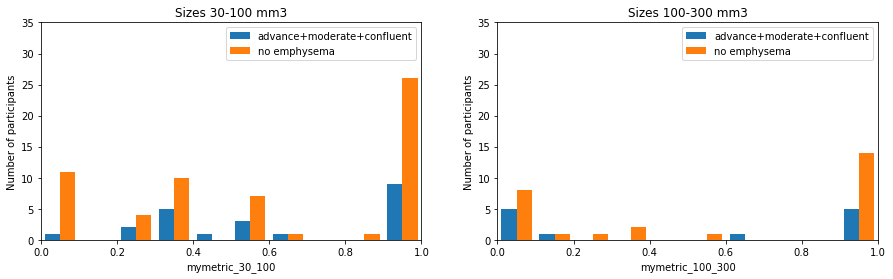

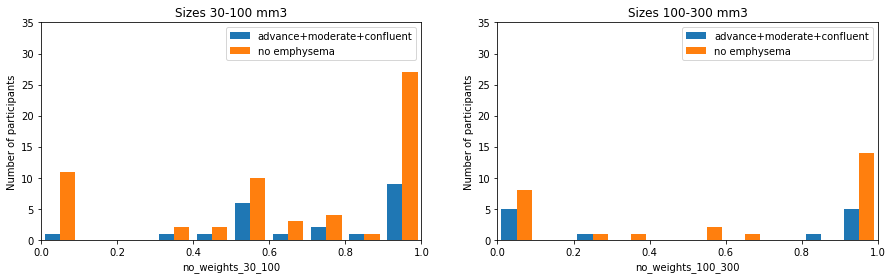

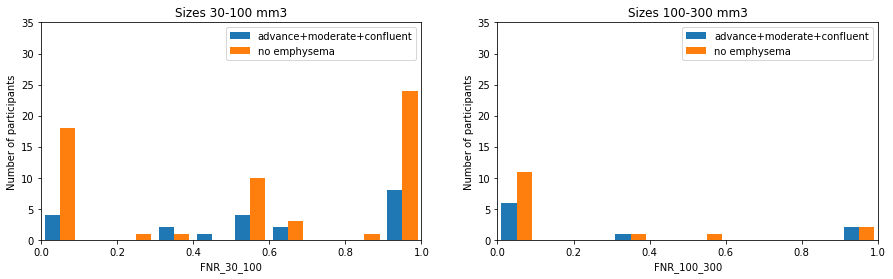

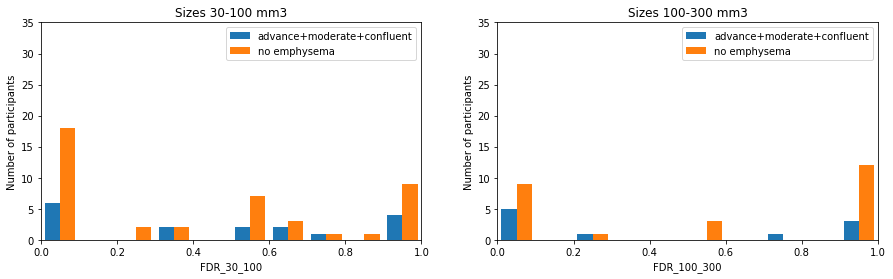

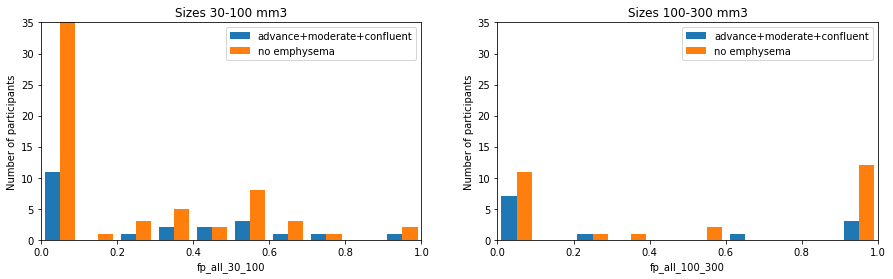

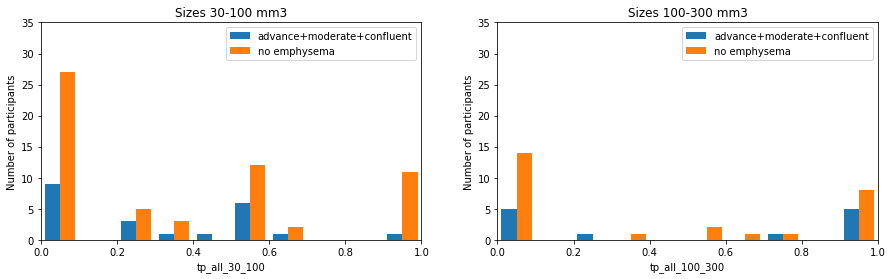

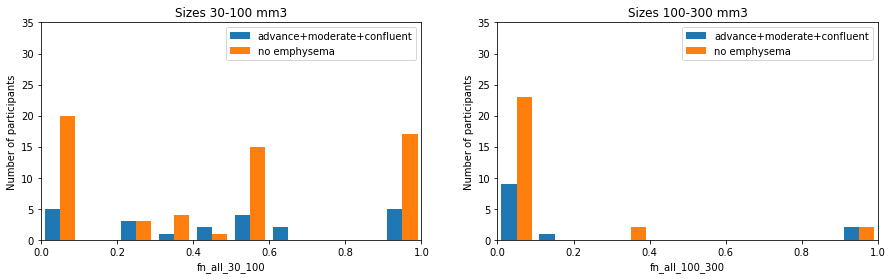

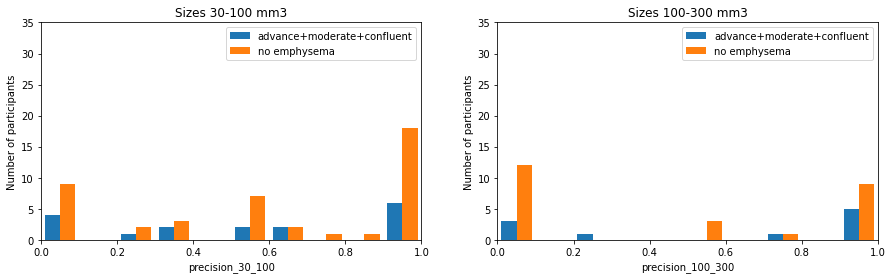

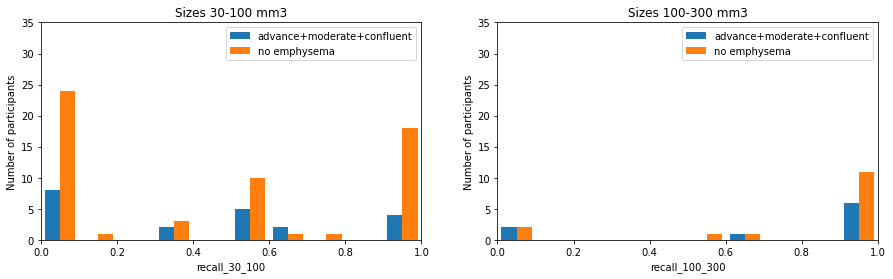

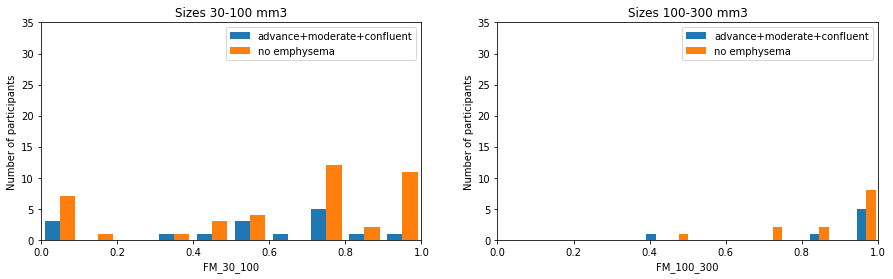

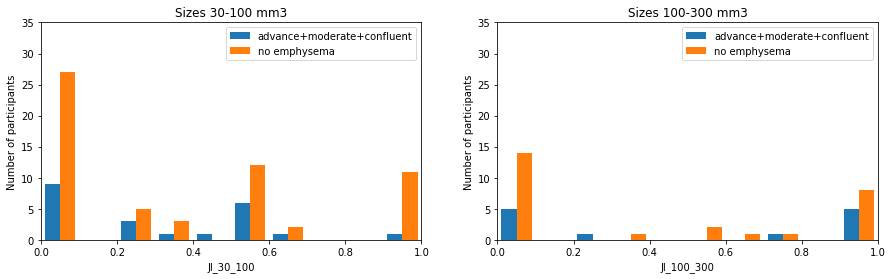

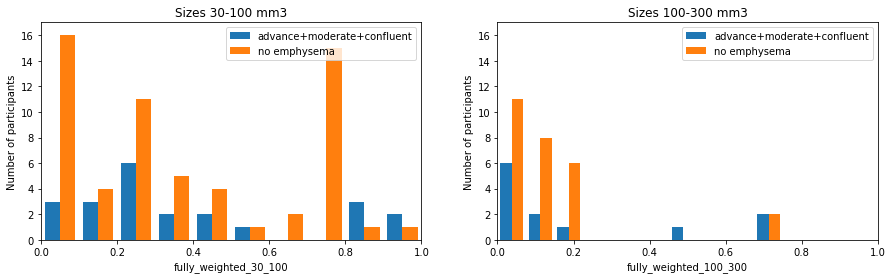

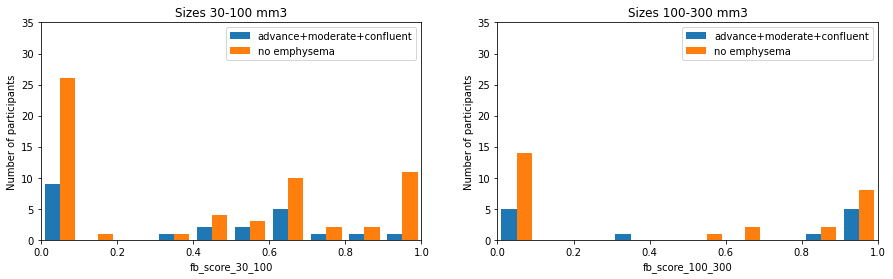

In [78]:
list_metrics=['mymetric','no_weights','FNR','FDR', 'fp_all', 'tp_all', 'fn_all',
              'precision','recall','FM','JI', #From 'precision' onwards not used in paper
              'fully_weighted','fb_score'] 

for metric in list_metrics:

    f, axs = plt.subplots(1,2,figsize=(15,4))

    # using subplot function and creating plot one
    plt.subplot(1, 2, 1)  
    plt.hist([list(mod_100[metric+'_0_100'])+list(adv_100[metric+'_0_100'])+list(conf_100[metric+'_0_100']),
              noemph_100[metric+'_0_100']], label=['advance+moderate+confluent', 'no emphysema'])
    plt.legend(loc='upper right')
    plt.title('Sizes 30-100 mm3')
    plt.ylabel('Number of participants') 
    plt.xlabel(str(metric)+'_30_100')
    plt.ylim(0, 35)
    plt.xlim(0,1)
    
    if metric=='fully_weighted':
        plt.ylim(0, 17)
        plt.xlim(0,1)

    plt.subplot(1, 2, 2)  
    plt.hist([list(mod_100_300[metric+'_100_300'])+list(adv_100_300[metric+'_100_300'])+
              list(conf_100_300[metric+'_100_300']),noemph_100_300[metric+'_100_300']], 
             label=['advance+moderate+confluent', 'no emphysema'])
    plt.legend(loc='upper right')
    plt.title('Sizes 100-300 mm3')
    plt.ylabel('Number of participants') 
    plt.xlabel(str(metric)+'_100_300')
    plt.ylim(0, 35)
    plt.xlim(0,1)
    
    if metric=='fully_weighted':
        plt.ylim(0, 17)
        plt.xlim(0,1)
        
#For volume subgroup 300+ - not used
#     plt.subplot(1, 3, 3) 
#     plt.hist([list(mod_300[metric+'_300'])+list(adv_300[metric+'_300'])+list(conf_300[metric+'_300']),
#               noemph_300[metric+'_300']], label=['advance+moderate+confluent', 'no emphysema'])
#     plt.legend(loc='upper right')
#     plt.title('Sizes >300 mm3')
#     plt.xlabel(str(metric)+'_300')

    # plt.savefig('Utest histograms')

#### Below similar graphs for just the number of TP, FP, and FNs if used as metric alone - only for individuals with nodules

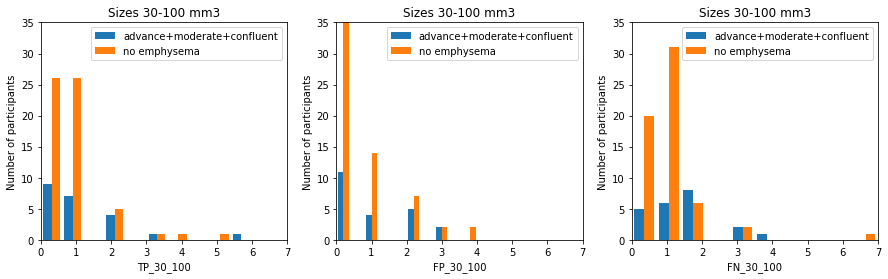

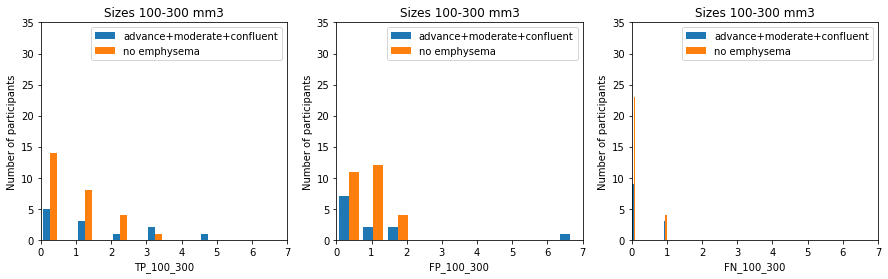

In [79]:
list_metrics_alone_100=['0-100tp','0-100fp','0-100fn'] 
list_metrics_alone_100_300=['100-300tp','100-300fp','100-300fn'] 

#Plots for subgroup 30-100mm3    
f, axs = plt.subplots(1,3,figsize=(15,4))

for index,metric_alone in enumerate(list_metrics_alone_100):

    # using subplot function and creating plot one
    plt.subplot(1, 3, index+1)
    plt.hist([list(mod_100[metric_alone])+list(adv_100[metric_alone])+list(conf_100[metric_alone]),noemph_100[metric_alone]], label=['advance+moderate+confluent', 'no emphysema'])
    plt.legend(loc='upper right')
    plt.title('Sizes 30-100 mm3')
    plt.ylabel('Number of participants')
    plt.xlabel(str(metric_alone)[5:].upper()+'_30_100')
    plt.ylim(0, 35)
    plt.xlim(0,7)

#Plots for subgroup 100-300mm3    
f, axs = plt.subplots(1,3,figsize=(15,4))

for index,metric_alone in enumerate(list_metrics_alone_100_300):

    plt.subplot(1, 3, index+1)  
    plt.hist([list(mod_100_300[metric_alone])+list(adv_100_300[metric_alone])+list(conf_100_300[metric_alone]),noemph_100_300[metric_alone]], label=['advance+moderate+confluent', 'no emphysema'])
    plt.legend(loc='upper right')
    plt.title('Sizes 100-300 mm3')
    plt.ylabel('Number of participants') 
    plt.xlabel(str(metric_alone)[7:].upper()+'_100_300')
    plt.ylim(0, 35)
    plt.xlim(0,7)
    
#Graph ticks not in the middle of bar - Maybe difficult to achieve this

#### Below similar graphs as above for individuals without nodules

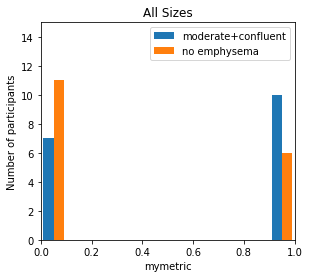

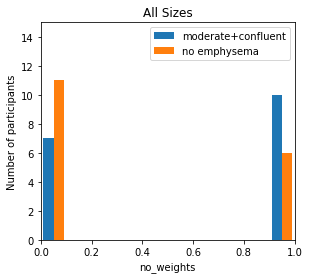

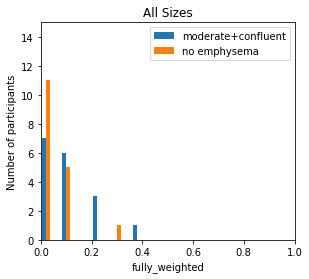

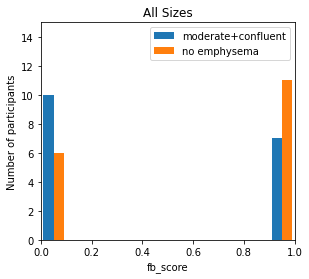

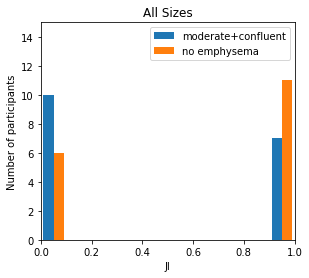

In [80]:
list_metrics=['mymetric','no_weights','fully_weighted','fb_score','JI'] #'FDR','precision' give errors here

for metric in list_metrics:

    f, axs = plt.subplots(1,1,figsize=(10,4))

    # using subplot function and creating plot one
    plt.subplot(1, 2, 1)  
    plt.hist([list(mod_no_fin[metric+'_0_100'])+list(conf_no_fin[metric+'_0_100']),emph_no_fin[metric+'_0_100']], label=['moderate+confluent', 'no emphysema'])
    plt.legend(loc='upper right')
    plt.title('All Sizes')
    plt.ylabel('Number of participants') 
    plt.xlabel(str(metric))
    plt.ylim(0, 15)
    plt.xlim(0,1)

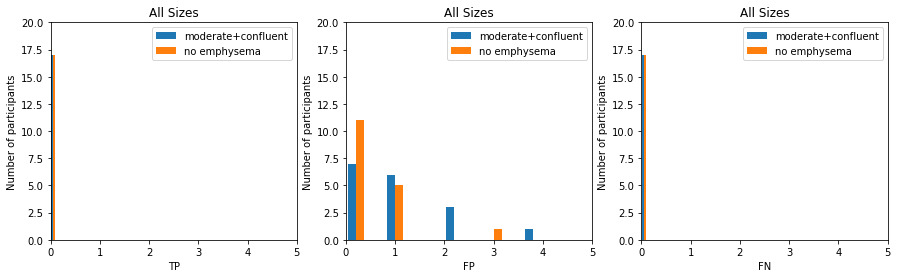

In [81]:
list_metrics_alone_100=['0-100tp','0-100fp','0-100fn'] 

f, axs = plt.subplots(1,3,figsize=(15,4))

for index,metric_alone in enumerate(list_metrics_alone_100):

    # using subplot function and creating plot one
    plt.subplot(1, 3, index+1)
    plt.hist([list(mod_no_fin[metric_alone])+list(conf_no_fin[metric_alone]),emph_no_fin[metric_alone]], label=['moderate+confluent', 'no emphysema'])
    plt.legend(loc='upper right')
    plt.title('All Sizes')
    plt.ylabel('Number of participants')
    plt.xlabel(str(metric_alone)[5:].upper())
    plt.ylim(0, 20)
    plt.xlim(0,5)

## Estimate sample size - Posthoc Analysis

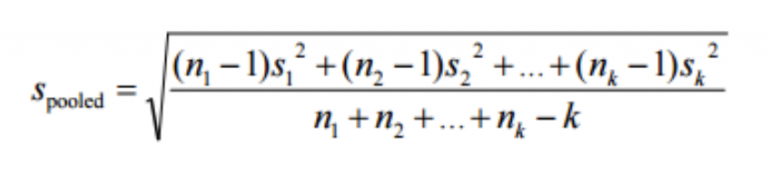
https://www.isixsigma.com/dictionary/pooled-standard-deviation/
n is the sample size of the group, S squared the group variance, and k the number of groups.

### Sample Size calculation

In [82]:
def mean_and_std_df(emphysema_df,non_emphysema_df):
    
    'Gets two dataframes with emphysema and non-emphysema cases, as extracted from the manual annotations excel files.'
    'returns df with metrics definition in each row and 3 columns with the mean of each of the emphysema/non-emphysema'
    'groups and the pooled std'
    
    # Based on above formula calculate pooled standard deviation for this subgroup, for each column of df
    #Since we have two groups the formula becomes: s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2)) 
    sp=np.sqrt(((len(emphysema_df)-1)*(emphysema_df.std()**2)+(len(non_emphysema_df)-1)*(non_emphysema_df.std()**2))/
               (len(emphysema_df)+len(non_emphysema_df)-2))
    #We should only keep columns related to the volume subgroup of interest. The rest should be neglected.

    #Calculate mean and std of each column for emphysema and nonemphysema groups and convert to df
    sp_new=sp.to_frame().reset_index() #pooled std refers to both groups
    non_emphysema_df_new=non_emphysema_df.mean().to_frame().reset_index()
    emphysema_df_new=emphysema_df.mean().to_frame().reset_index()
    
    # #Check for inconsistencies - columns that cannot be found in dfs of std and means of both groups
    # for i in sp_new['index'].values:
    #     if i not in emphysema_df_new['index'].values:
    #         print(i)

    # for i in emphysema_df_new['index'].values:
    #     if i not in sp_new['index'].values:
    #         print(i)

    # for i in sp_new['index'].values:
    #     if i not in non_emphysema_df_new['index'].values:
    #         print(i)

    # for i in non_emphysema_df_new['index'].values:
    #     if i not in sp_new['index'].values:
    #         print(i)
    
    #Sort values in all of them to ensure same order
    sp_new=sp_new.sort_values(by=['index'])
    emphysema_df_new=emphysema_df_new.sort_values(by=['index'])
    non_emphysema_df_new=non_emphysema_df_new.sort_values(by=['index'])

    #Confirm that we have the same order - Should always work, otherwise sth is missing - activate above in that case
    np.sum(sp_new['index']==emphysema_df_new['index'])==len(emphysema_df_new)
    np.sum(sp_new['index']==non_emphysema_df_new['index'])==len(non_emphysema_df_new)
    
    df_new=emphysema_df_new.copy() #Get a copy of emphysema df
    df_new.rename(columns={'index': 'metrics', 0: 'emp_mean'}, inplace=True) #Rename columns
    df_new['noemp_mean']=non_emphysema_df_new[0] #Add noemphysema means in that
    df_new['sp']=sp_new[0] #Add pooled std in that
    
    #Add effect size and sample size columns to be filled below - for now just filled with 0s.
    df_new['Effect size']=0
    df_new['Sample size in each group']=0

    return df_new

In [83]:
def effect_size_and_pooled_std(df,emphysema_df,non_emphysema_df,subgroup='_100'):
    
    'Gets a df with a colume with metrics, one with emphysema, one without emphysema means, one with pooled std,'
    'and two zero ones to be filled with effect size and sample size. It also takes an argument specifying'
    'the subgroup of interest ["_100","_100_300","nonods"]'
    'Returns a df with effect size and sample size calculated'
    
    #https://www.geeksforgeeks.org/introduction-to-power-analysis-in-python/
    #https://www.statsmodels.org/dev/generated/statsmodels.stats.power.TTestIndPower.html

    #Below group 1 refers to the emphysema group and group 2 to the non-emphysema group - Order is important

    for metric_def in range(len(df)): #Loop over the total number of rows - metrics

        # size of samples in pilot study - first emphysema group, the same everywhere below
        n1, n2 = len(emphysema_df),len(non_emphysema_df)

        # calculate the pooled standard deviation (Cohen's d)
        s=df.iloc[metric_def]['sp']

        # means of the samples - first emphysema group
        u1, u2 = df.iloc[metric_def]['emp_mean'], df.iloc[metric_def]['noemp_mean']
        
        if subgroup=='_100' or subgroup=="nonods":
            condition=('_100' in df.iloc[metric_def]['metrics'] or '0-100' in df.iloc[metric_def]['metrics'])
        elif subgroup=="_100_300":
            condition=('100_300' in df.iloc[metric_def]['metrics'] or '100-300' in df.iloc[metric_def]['metrics'])       
        else:
            condition=False
            print("Not valid subgroup")

        #We set s!=0 to ensure that this metric was calculated and is non-zero. 
        #We also check only columns that have information for the volume subgroup of interest and not of all of them
        if s!=0 and condition==True:

            # calculate the effect size
            d = np.abs(u1 - u2) / s #np.abs added to avoid negative effect sizes
    #         print('Metric used is',df.iloc[metric_def]['metrics'])
    #         print(f'Effect size: {d}')

            # factors for power analysis
            alpha = 0.05
            power = 0.80
            
            # perform power analysis to find sample size for a given effect (calculated above)
            obj = TTestIndPower() #Initialize the object to help us do that
            n = obj.solve_power(effect_size=d, alpha=alpha, power=power, 
                                ratio=n1/n2, alternative='two-sided') 
            #Ratio set to n1/n2 and not 1 - not equal group sizes

    #         print('Sample size/Number needed in each group: {:.3f}'.format(int(np.ceil(n))))
    #         print('\n')

            #Add above values to the corresponding column
            df.loc[df.index[metric_def], 'Effect size']=d
            df.loc[df.index[metric_def], 'Sample size in each group']=int(np.ceil(n))
            
    return df

#### Sample size calculation for volume subgroup 30-100mm$^{3}$

In [84]:
#Create df by combining all emphysema degrees for volume subgroup 30-100mm3
emph_100=mod_100.append(adv_100)
emph_100=emph_100.append(conf_100).reset_index(drop=True)
emph_100.iloc[:,31:]

,mymetric_0_100,mymetric_100_300,mymetric_300,no_weights_0_100,no_weights_100_300,no_weights_300,fully_weighted_0_100,fully_weighted_100_300,fully_weighted_300,fb_score_0_100,...,FNR_300,FM_0_100,FM_100_300,FM_300,FDR_0_100,FDR_100_300,FDR_300,JI_0_100,JI_100_300,JI_300
0,0.333333,0.000000,0.0,0.500000,0.000000,0.0,0.066667,0.000000,0.0,0.666667,...,NaN,0.707107,1.000000,NaN,0.500000,0.000000,NaN,0.500000,1.000000,1.0
1,0.200000,1.000000,0.0,0.333333,1.000000,0.0,0.020000,0.750000,0.0,0.800000,...,NaN,0.816497,NaN,NaN,0.333333,NaN,NaN,0.666667,0.000000,1.0
2,0.600000,0.000000,0.0,0.750000,0.000000,0.0,0.230000,0.000000,0.0,0.400000,...,NaN,0.408248,NaN,NaN,0.666667,NaN,NaN,0.250000,1.000000,1.0
3,0.333333,1.000000,0.0,0.500000,1.000000,0.0,0.283333,0.100000,0.0,0.666667,...,NaN,0.707107,NaN,NaN,0.000000,1.000000,NaN,0.500000,0.000000,1.0
4,0.666667,0.000000,0.0,0.800000,0.000000,0.0,0.350000,0.000000,0.0,0.333333,...,NaN,0.333333,NaN,NaN,0.666667,NaN,NaN,0.200000,1.000000,1.0
5,1.000000,0.000000,0.0,1.000000,0.000000,0.0,0.850000,0.000000,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,1.0
6,0.333333,0.000000,0.0,0.500000,0.000000,0.0,0.250000,0.000000,0.0,0.666667,...,NaN,0.707107,NaN,NaN,0.000000,NaN,NaN,0.500000,1.000000,1.0
7,1.000000,0.000000,0.0,1.000000,0.000000,0.0,0.600000,0.000000,0.0,0.000000,...,NaN,0.000000,NaN,NaN,1.000000,NaN,NaN,0.000000,1.000000,1.0
8,1.000000,1.000000,0.0,1.000000,1.000000,0.0,0.850000,0.100000,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.000000,0.000000,1.0
9,1.000000,0.666667,1.0,1.000000,0.800000,1.0,0.850000,0.470833,0.1,0.000000,...,NaN,NaN,0.384900,NaN,NaN,0.777778,1.0,0.000000,0.200000,0.0


In [85]:
print("Total number of columns for which std/mean is calculated for noemphysema 30-100mm\u00b3 is {}".format(len(noemph_100.std())))
print("Total number of columns for which std/mean is calculated for emphysema 30-100mm\u00b3 is {}".format(len(emph_100.std())))

Total number of columns for which std/mean is calculated for noemphysema 30-100mm³ is 58
Total number of columns for which std/mean is calculated for emphysema 30-100mm³ is 58


In [86]:
print("Total number of individuals in noemphysema of 30-100mm\u00b3 is {}".format(len(noemph_100)))
print("Total number of individuals in emphysema of 30-100mm\u00b3 is {}".format(len(emph_100)))

Total number of individuals in noemphysema of 30-100mm³ is 60
Total number of individuals in emphysema of 30-100mm³ is 22


In [87]:
df_100=mean_and_std_df(emph_100,noemph_100)
df_new_100=effect_size_and_pooled_std(df_100,emph_100,noemph_100)
df_new_100

,metrics,emp_mean,noemp_mean,sp,Effect size,Sample size in each group
16,0-100fn,1.454545,0.933333,1.090802,0.477825,130
13,0-100fp,0.909091,0.700000,1.039340,0.201177,725
10,0-100tp,1.090909,0.800000,1.114777,0.260957,432
17,100-300fn,0.136364,0.050000,0.260790,0.000000,0
14,100-300fp,0.590909,0.333333,0.952966,0.000000,0
11,100-300tp,0.727273,0.183333,0.831767,0.000000,0
18,300+ fn,0.000000,0.000000,0.000000,0.000000,0
15,300+ fp,0.045455,0.083333,0.379768,0.000000,0
12,300+ tp,0.045455,0.116667,0.603509,0.000000,0
52,FDR_0_100,0.455882,0.399225,0.402460,0.140778,1478


###### Moves to Latex

In [88]:
columns_print=['metrics','Effect size','Sample size in each group']

rows_keep=[x for x in df_new_100['metrics'] if '_0_100' in x] #row names to keep
print(df_new_100.loc[df_new_100['metrics'].isin(rows_keep)][columns_print].to_latex(index=False)
      .replace("\\\n", "\\ \hline\n")) #To be copied to latex/overleaf

df_print=df_new_100.loc[df_new_100['metrics'].isin(rows_keep)]

df_print=df_print[columns_print]
display(HTML(df_print.to_html())) #Another, better way to display

\begin{tabular}{lrr}
\toprule
             metrics &  Effect size &  Sample size in each group \\ \hline
\midrule
           FDR\_0\_100 &     0.140778 &                       1478 \\ \hline
            FM\_0\_100 &     0.232561 &                        543 \\ \hline
           FNR\_0\_100 &     0.073543 &                       5411 \\ \hline
            JI\_0\_100 &     0.180645 &                        898 \\ \hline
      fb\_score\_0\_100 &     0.098076 &                       3043 \\ \hline
        fn\_all\_0\_100 &     0.024498 &                      48749 \\ \hline
        fp\_all\_0\_100 &     0.193909 &                        780 \\ \hline
fully\_weighted\_0\_100 &     0.106335 &                       2589 \\ \hline
      mymetric\_0\_100 &     0.098076 &                       3043 \\ \hline
    no\_weights\_0\_100 &     0.180645 &                        898 \\ \hline
     precision\_0\_100 &     0.140778 &                       1478 \\ \hline
        recall\_0\_100 &     0.073

,metrics,Effect size,Sample size in each group
52,FDR_0_100,0.140778,1478
49,FM_0_100,0.232561,543
46,FNR_0_100,0.073543,5411
55,JI_0_100,0.180645,898
28,fb_score_0_100,0.098076,3043
40,fn_all_0_100,0.024498,48749
34,fp_all_0_100,0.193909,780
25,fully_weighted_0_100,0.106335,2589
19,mymetric_0_100,0.098076,3043
22,no_weights_0_100,0.180645,898


#### Sample size calculation for volume subgroup 100-300mm$^{3}$

In [89]:
emph_100_300=mod_100_300.append(adv_100_300)
emph_100_300=emph_100_300.append(conf_100_300).reset_index(drop=True)

In [90]:
print("Total number of columns for which std/mean is calculated for noemphysema 100-300mm\u00b3 is {}".format(len(noemph_100_300.std())))
print("Total number of columns for which std/mean is calculated for emphysema 100-300mm\u00b3 is {}".format(len(emph_100_300.std())))

Total number of columns for which std/mean is calculated for noemphysema 100-300mm³ is 58
Total number of columns for which std/mean is calculated for emphysema 100-300mm³ is 58


In [91]:
print("Total number of individuals in noemphysema of 100-300mm\u00b3 is {}".format(len(noemph_100_300)))
print("Total number of individuals in emphysema of 100-300mm\u00b3 is {}".format(len(emph_100_300)))

Total number of individuals in noemphysema of 100-300mm³ is 27
Total number of individuals in emphysema of 100-300mm³ is 12


In [92]:
df_100_300=mean_and_std_df(emph_100_300,noemph_100_300)
df_new_100_300=effect_size_and_pooled_std(df_100_300,emph_100_300,noemph_100_300,subgroup='_100_300')
df_new_100_300

,metrics,emp_mean,noemp_mean,sp,Effect size,Sample size in each group
16,0-100fn,1.333333,0.888889,1.368895,0.000000,0
13,0-100fp,1.000000,0.925926,1.271856,0.000000,0
10,0-100tp,1.583333,0.444444,1.109947,0.000000,0
17,100-300fn,0.250000,0.148148,0.391028,0.260472,378
14,100-300fp,1.083333,0.740741,1.253124,0.273391,343
11,100-300tp,1.333333,0.703704,1.142500,0.551098,86
18,300+ fn,0.000000,0.000000,0.000000,0.000000,0
15,300+ fp,0.083333,0.111111,0.311202,0.000000,0
12,300+ tp,0.083333,0.444444,1.371361,0.000000,0
52,FDR_0_100,0.379630,0.591667,0.398617,0.000000,0


###### Moves to Latex

In [93]:
columns_print=['metrics','Effect size','Sample size in each group']

rows_keep=[x for x in df_new_100_300['metrics'] if '_100_300' in x] #row names to keep
print(df_new_100_300.loc[df_new_100_300['metrics'].isin(rows_keep)][columns_print].to_latex(index=False)
      .replace("\\\n", "\\ \hline\n")) #To be copied to latex/overleaf

df_print=df_new_100_300.loc[df_new_100_300['metrics'].isin(rows_keep)]

df_print=df_print[columns_print]
display(HTML(df_print.to_html())) #Another, better way to display

\begin{tabular}{lrr}
\toprule
               metrics &  Effect size &  Sample size in each group \\ \hline
\midrule
           FDR\_100\_300 &     0.305605 &                        275 \\ \hline
            FM\_100\_300 &     0.011018 &                     210134 \\ \hline
           FNR\_100\_300 &     0.183153 &                        762 \\ \hline
            JI\_100\_300 &     0.204021 &                        615 \\ \hline
      fb\_score\_100\_300 &     0.186916 &                        732 \\ \hline
        fn\_all\_100\_300 &     0.244354 &                        429 \\ \hline
        fp\_all\_100\_300 &     0.365627 &                        193 \\ \hline
fully\_weighted\_100\_300 &     0.305276 &                        276 \\ \hline
      mymetric\_100\_300 &     0.186916 &                        732 \\ \hline
    no\_weights\_100\_300 &     0.204021 &                        615 \\ \hline
     precision\_100\_300 &     0.305605 &                        275 \\ \hline
        re

,metrics,Effect size,Sample size in each group
53,FDR_100_300,0.305605,275
50,FM_100_300,0.011018,210134
47,FNR_100_300,0.183153,762
56,JI_100_300,0.204021,615
29,fb_score_100_300,0.186916,732
41,fn_all_100_300,0.244354,429
35,fp_all_100_300,0.365627,193
26,fully_weighted_100_300,0.305276,276
20,mymetric_100_300,0.186916,732
23,no_weights_100_300,0.204021,615


#### Sample size calculation for subgroup without nodules

In [94]:
emph_yes=mod_no_fin.append(conf_no_fin)
emph_yes=emph_yes.reset_index(drop=True)

In [95]:
print("Total number of columns for which std/mean is calculated for noemphysema 30-100mm\u00b3 is {}".format(len(emph_no_fin.std())))
print("Total number of columns for which std/mean is calculated for emphysema 30-100mm\u00b3 is {}".format(len(emph_yes.std())))

Total number of columns for which std/mean is calculated for noemphysema 30-100mm³ is 33
Total number of columns for which std/mean is calculated for emphysema 30-100mm³ is 33


In [96]:
print("Total number of individuals in noemphysema of 30-100mm\u00b3 is {}".format(len(emph_no_fin)))
print("Total number of individuals in emphysema of 30-100mm\u00b3 is {}".format(len(emph_yes)))

Total number of individuals in noemphysema of 30-100mm³ is 17
Total number of individuals in emphysema of 30-100mm³ is 17


In [97]:
df_nonods=mean_and_std_df(emph_yes,emph_no_fin)
df_nonods_new=effect_size_and_pooled_std(df_nonods,emph_yes,emph_no_fin,subgroup='nonods')
df_nonods_new #Below very close but not exactly the same as GPower program (for FP)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\power.py:415: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\power.py:415: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)


,metrics,emp_mean,noemp_mean,sp,Effect size,Sample size in each group
2,0-100fn,0.000000,0.000000,0.000000,0.000000,0
1,0-100fp,0.941176,0.470588,0.954864,0.492833,66
0,0-100tp,0.000000,0.000000,0.000000,0.000000,0
27,FDR_0_100,1.000000,1.000000,0.000000,0.000000,0
28,FDR_100_300,NaN,NaN,NaN,NaN,10
29,FDR_300,NaN,NaN,NaN,0.000000,0
30,JI_0_100,0.411765,0.647059,0.500000,0.470588,72
31,JI_100_300,1.000000,1.000000,0.000000,0.000000,0
32,JI_300,1.000000,1.000000,0.000000,0.000000,0
12,fb_score_0_100,0.411765,0.647059,0.500000,0.470588,72


###### Moves to Latex

In [98]:
columns_print=['metrics','Effect size','Sample size in each group']

rows_keep=[x for x in df_nonods_new['metrics'] if '_0_100' in x] #row names to keep
print(df_nonods_new.loc[df_nonods_new['metrics'].isin(rows_keep)][columns_print].to_latex(index=False)
      .replace("\\\n", "\\ \hline\n")) #To be copied to latex/overleaf

df_print=df_nonods_new.loc[df_nonods_new['metrics'].isin(rows_keep)]

# Added since these have 0 values everywhere
df_print = df_print[df_print.metrics != 'FDR_0_100']
df_print = df_print[df_print.metrics != 'precision_0_100']

df_print=df_print[columns_print]
display(HTML(df_print.to_html())) #Another, better way to display

\begin{tabular}{lrr}
\toprule
             metrics &  Effect size &  Sample size in each group \\ \hline
\midrule
           FDR\_0\_100 &     0.000000 &                          0 \\ \hline
            JI\_0\_100 &     0.470588 &                         72 \\ \hline
      fb\_score\_0\_100 &     0.470588 &                         72 \\ \hline
        fn\_all\_0\_100 &     0.000000 &                          0 \\ \hline
        fp\_all\_0\_100 &     0.470588 &                         72 \\ \hline
fully\_weighted\_0\_100 &     0.492833 &                         66 \\ \hline
      mymetric\_0\_100 &     0.470588 &                         72 \\ \hline
    no\_weights\_0\_100 &     0.470588 &                         72 \\ \hline
     precision\_0\_100 &     0.000000 &                          0 \\ \hline
        tp\_all\_0\_100 &     0.000000 &                          0 \\ \hline
\bottomrule
\end{tabular}



,metrics,Effect size,Sample size in each group
30,JI_0_100,0.470588,72
12,fb_score_0_100,0.470588,72
24,fn_all_0_100,0.000000,0
18,fp_all_0_100,0.470588,72
9,fully_weighted_0_100,0.492833,66
3,mymetric_0_100,0.470588,72
6,no_weights_0_100,0.470588,72
21,tp_all_0_100,0.000000,0


##### Power curves plots

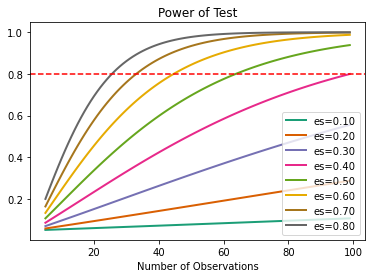

In [99]:
# power analysis varying parameters
effect_sizes = 0.1*np.array(range(1,9,1))
sample_sizes = np.array(range(5, 100))
  
# plot power curves
obj = TTestIndPower()
obj.plot_power(dep_var='nobs', nobs=sample_sizes,
               effect_size=effect_sizes)

plt.axhline(y = 0.8, color = 'r', linestyle = 'dashed')

plt.show()

In [100]:
#test the power of a specific proposed sample size. 
  
power = TTestPower()
n_test = power.solve_power(nobs=40, effect_size = 0.7,
                           power = None, alpha = 0.05)

print('Power: {:.3f}'.format(n_test))

Power: 0.991


## Statistical tests

In [101]:
#Mean and stds for each of the emphysema-nonemphysema groups and for each volume subgroup/non-nodule group
print('Mean FP value for 0-100 emphysema is ',np.mean(emph_100['fp_all_0_100']), 'and std is ',np.std(emph_100['fp_all_0_100']))
print('Mean FP value for 0-100 non-emphysema is ',np.mean(noemph_100['fp_all_0_100']), 'and std is ',np.std(noemph_100['fp_all_0_100']))

print('Mean TP value for 0-100 emphysema is ',np.mean(emph_100['tp_all_0_100']), 'and std is ',np.std(emph_100['tp_all_0_100']))
print('Mean TP value for 0-100 non-emphysema is ',np.mean(noemph_100['tp_all_0_100']), 'and std is ',np.std(noemph_100['tp_all_0_100']))

print('Mean FN value for 0-100 emphysema is ',np.mean(emph_100['fn_all_0_100']), 'and std is ',np.std(emph_100['fn_all_0_100']))
print('Mean FN value for 0-100 non-emphysema is ',np.mean(noemph_100['fn_all_0_100']), 'and std is ',np.std(noemph_100['fn_all_0_100']))
print('\n')


print('Mean FP value for 100-300 emphysema is ',np.mean(emph_100_300['fp_all_100_300']), 'and std is ',np.std(emph_100_300['fp_all_100_300']))
print('Mean FP value for 100-300 non-emphysema is ',np.mean(noemph_100_300['fp_all_100_300']), 'and std is ',np.std(noemph_100_300['fp_all_100_300']))

print('Mean TP value for 100-300 emphysema is ',np.mean(emph_100_300['tp_all_100_300']), 'and std is ',np.std(emph_100_300['tp_all_100_300']))
print('Mean TP value for 100-300 non-emphysema is ',np.mean(noemph_100_300['tp_all_100_300']), 'and std is ',np.std(noemph_100_300['tp_all_100_300']))

print('Mean FN value for 100-300 emphysema is ',np.mean(emph_100_300['fn_all_100_300']), 'and std is ',np.std(emph_100_300['fn_all_100_300']))
print('Mean FN value for 100-300 non-emphysema is ',np.mean(noemph_100_300['fn_all_100_300']), 'and std is ',np.std(noemph_100_300['fn_all_100_300']))
print('\n')


print('Mean FP value for non-nodule emphysema is ',np.mean(emph_yes['fp_all_0_100']), 'and std is ',np.std(emph_yes['fp_all_0_100']))
print('Mean FP value for non-nodule non-emphysema is ',np.mean(emph_no_fin['fp_all_0_100']), 'and std is ',np.std(emph_no_fin['fp_all_0_100']))

Mean FP value for 0-100 emphysema is  0.2560606060606061 and std is  0.29535740438815045
Mean FP value for 0-100 non-emphysema is  0.20099206349206347 and std is  0.2748614340883522
Mean TP value for 0-100 emphysema is  0.2818181818181818 and std is  0.2814962318723119
Mean TP value for 0-100 non-emphysema is  0.346468253968254 and std is  0.3764589888784464
Mean FN value for 0-100 emphysema is  0.46212121212121215 and std is  0.35590905865809935
Mean FN value for 0-100 non-emphysema is  0.45253968253968246 and std is  0.3968905184660804


Mean FP value for 100-300 emphysema is  0.33214285714285713 and std is  0.43280154444126967
Mean FP value for 100-300 non-emphysema is  0.5030864197530864 and std is  0.46507747566964336
Mean TP value for 100-300 emphysema is  0.4928571428571429 and std is  0.4686244162838882
Mean TP value for 100-300 non-emphysema is  0.39814814814814814 and std is  0.44463730383492484
Mean FN value for 100-300 emphysema is  0.17500000000000002 and std is  0.3699662

In [102]:
# Create lists for the plot - https://pythonforundergradengineers.com/python-matplotlib-error-bars.html

groups = ['FP_emp', 'FP_non-emp','TP_emp', 'TP_non-emp', 'FN_emp', 'FN_non-emp']

x_pos = np.arange(len(groups))

means = [np.mean(emph_100['fp_all_0_100']), np.mean(noemph_100['fp_all_0_100']),np.mean(emph_100['tp_all_0_100']),
        np.mean(noemph_100['tp_all_0_100']),np.mean(emph_100['fn_all_0_100']),np.mean(noemph_100['fn_all_0_100'])]

error = [np.std(emph_100['fp_all_0_100']), np.std(noemph_100['fp_all_0_100']), np.std(emph_100['tp_all_0_100']),
        np.std(noemph_100['tp_all_0_100']),np.std(emph_100['fn_all_0_100']),np.std(noemph_100['fn_all_0_100'])]

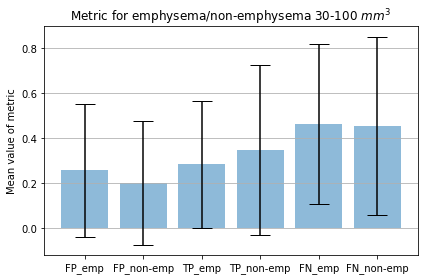

In [103]:
# Build the plot

fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean value of metric')
ax.set_xticks(x_pos)
ax.set_xticklabels(groups)

ax.set_title('Metric for emphysema/non-emphysema 30-100 $mm^{3}$')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()

In [104]:
# #box and whiskers plot - Not proper since whiskers show min-max values
# #https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/

# fig = plt.figure(figsize =(10, 7))
 
# data=[emph_100['fp_all_0_100'].values, noemph_100['fp_all_0_100'].values,emph_100['tp_all_0_100'].values,
#       noemph_100['tp_all_0_100'].values,emph_100['fn_all_0_100'].values,noemph_100['fn_all_0_100'].values]

# # Creating plot
# plt.boxplot(data)
# plt.xticks([1, 2, 3,4,5,6], groups)

# # show plot
# plt.show()

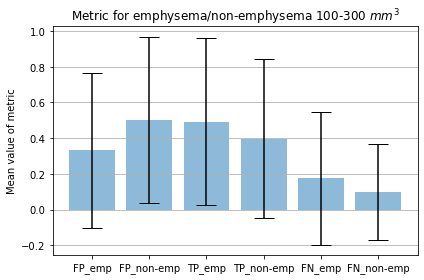

In [105]:
#Similarly for volume subgroup 30-100mm3

groups = ['FP_emp', 'FP_non-emp','TP_emp', 'TP_non-emp','FN_emp', 'FN_non-emp']

x_pos = np.arange(len(groups))

means = [np.mean(emph_100_300['fp_all_100_300']),np.mean(noemph_100_300['fp_all_100_300']),np.mean(emph_100_300['tp_all_100_300']),
        np.mean(noemph_100_300['tp_all_100_300']),np.mean(emph_100_300['fn_all_100_300']),np.mean(noemph_100_300['fn_all_100_300'])]

error = [np.std(emph_100_300['fp_all_100_300']),np.std(noemph_100_300['fp_all_100_300']),np.std(emph_100_300['tp_all_100_300']),
        np.std(noemph_100_300['tp_all_100_300']),np.std(emph_100_300['fn_all_100_300']),np.std(noemph_100_300['fn_all_100_300'])]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean value of metric')
ax.set_xticks(x_pos)
ax.set_xticklabels(groups)

ax.set_title('Metric for emphysema/non-emphysema 100-300 $mm^{3}$')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()

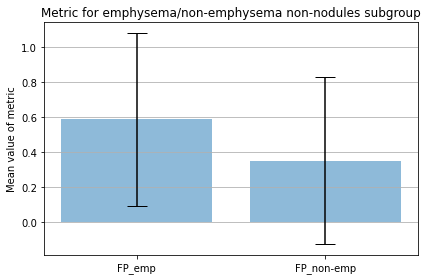

In [106]:
#Similarly for non-nodule subgroup

groups = ['FP_emp', 'FP_non-emp']
x_pos = np.arange(len(groups))
means = [np.mean(emph_yes['fp_all_0_100']),np.mean(emph_no_fin['fp_all_0_100'])]
error = [np.std(emph_yes['fp_all_0_100']),np.std(emph_no_fin['fp_all_0_100'])]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean value of metric')
ax.set_xticks(x_pos)
ax.set_xticklabels(groups)

ax.set_title('Metric for emphysema/non-emphysema non-nodules subgroup')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()

###### Statistical analysis - One way ANOVA (Kruskal test) + Mann-Whitney U test

https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide.php

One-way ANOVA is an omnibus test statistic and cannot tell you which specific groups were statistically significantly
different from each other, only that at least two groups were. To determine which specific groups differed from each 
other, you need to use a post hoc test. 

Every time you conduct a t-test there is a chance that you will make a Type I error. This error is usually 5%. 
By running two t-tests on the same data you will have increased your chance of "making a mistake" to 10%.
The formula for determining the new error rate for multiple t-tests is not as simple as multiplying 5% by the number 
of tests. However, if you are only making a few multiple comparisons, the results are very similar if you do. 
As such, three t-tests would be 15% (actually, 14.3%) and so on. These are unacceptable errors. 
An ANOVA controls for these errors so that the Type I error remains at 5% and you can be more confident that any 
statistically significant result you find is not just running lots of tests

Assumptions:
1) The dependent variable is normally distributed in each group

2) There is homogeneity of variances. This means that the population variances in each group are equal. 

3) There is independence of observations. 


How to report it:

statistics value, p value and mean+-std. For example, if difference report as 'statistically significant difference', 
if no difference report as 'There were no statistically significant differences between group means as 
determined by one-way ANOVA 'F(2,27) = 1.397, p = .15'. 
We need to run a post-hoc test to check which group has a larger mean than the other

In [107]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html

#One way ANOVA

from scipy.stats import f_oneway 

print('FP check for 0-100:',f_oneway(emph_100['fp_all_0_100'],noemph_100['fp_all_0_100']))
print('TP check for 0-100:',f_oneway(emph_100['tp_all_0_100'],noemph_100['tp_all_0_100']))
print('FN check for 0-100:',f_oneway(emph_100['fn_all_0_100'],noemph_100['fn_all_0_100']))
print('\n')

print('FP check for 100-300:',f_oneway(emph_100_300['fp_all_100_300'],noemph_100_300['fp_all_100_300']))
print('TP check for 100-300:',f_oneway(emph_100_300['tp_all_100_300'],noemph_100_300['tp_all_100_300']))
print('FN check for 100-300:',f_oneway(emph_100_300['fn_all_100_300'],noemph_100_300['fn_all_100_300']))
print('\n')

print('FP check for non-nodules:',f_oneway(emph_yes['fp_all_0_100'],emph_no_fin['fp_all_0_100']))

FP check for 0-100: F_onewayResult(statistic=0.6052778321687308, pvalue=0.4388662268325463)
TP check for 0-100: F_onewayResult(statistic=0.5253028925597258, pvalue=0.4707028983835665)
FN check for 0-100: F_onewayResult(statistic=0.009660642632783328, pvalue=0.9219490091444711)


FP check for 100-300: F_onewayResult(statistic=1.1105951995885175, pvalue=0.29878616048571827)
TP check for 100-300: F_onewayResult(statistic=0.3458025247233047, pvalue=0.5600713327754561)
FN check for 100-300: F_onewayResult(statistic=0.496044862034389, pvalue=0.48565273124492636)


FP check for non-nodules: F_onewayResult(statistic=1.8823529411764706, pvalue=0.17960943244093597)


In [108]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal

from scipy.stats import kruskal

print('FP check for 0-100:',kruskal(emph_100['fp_all_0_100'],noemph_100['fp_all_0_100']))
print('TP check for 0-100:',kruskal(emph_100['tp_all_0_100'],noemph_100['tp_all_0_100']))
print('FN check for 0-100:',kruskal(emph_100['fn_all_0_100'],noemph_100['fn_all_0_100']))
print('\n')

print('FP check for 100-300:',kruskal(emph_100_300['fp_all_100_300'],noemph_100_300['fp_all_100_300']))
print('TP check for 100-300:',kruskal(emph_100_300['tp_all_100_300'],noemph_100_300['tp_all_100_300']))
print('FN check for 100-300:',kruskal(emph_100_300['fn_all_100_300'],noemph_100_300['fn_all_100_300']))
print('\n')

print('FP check for non-nodules:',kruskal(emph_yes['fp_all_0_100'],emph_no_fin['fp_all_0_100']))

#Similar results apart from TP 0-100 which value is very different from ANOVA, but still not significant p value

FP check for 0-100: KruskalResult(statistic=0.5729159102067607, pvalue=0.4491025323696055)
TP check for 0-100: KruskalResult(statistic=0.1733205823802744, pvalue=0.6771774060611643)
FN check for 0-100: KruskalResult(statistic=0.026127552176401395, pvalue=0.8715892036114163)


FP check for 100-300: KruskalResult(statistic=1.2295220669771727, pvalue=0.26750000479576463)
TP check for 100-300: KruskalResult(statistic=0.4369264787175527, pvalue=0.5086096558446582)
FN check for 100-300: KruskalResult(statistic=0.5643741974469646, pvalue=0.452503161294842)


FP check for non-nodules: KruskalResult(statistic=1.8333333333333457, pvalue=0.1757343356442198)


In [109]:
# Print the variance of both data groups. If the ratio is greater than 4:1 the variance is different 
# and so, we can apply Welch’s t-test. 

#https://www.geeksforgeeks.org/welchs-t-test-in-python/

print('FP check variance ratio for 0-100:',np.var(emph_100['fp_all_0_100'])/np.var(noemph_100['fp_all_0_100']))
print('TP check variance ratio for 0-100:',np.var(emph_100['tp_all_0_100'])/np.var(noemph_100['tp_all_0_100']))
print('FN check variance ratio for 0-100:',np.var(emph_100['fn_all_0_100'])/np.var(noemph_100['fn_all_0_100']))
print('\n')

print('FP check variance ratio for 100-300:',np.var(emph_100_300['fp_all_100_300'])/np.var(noemph_100_300['fp_all_100_300']))
print('TP check variance ratio for 100-300:',np.var(emph_100_300['tp_all_100_300'])/np.var(noemph_100_300['tp_all_100_300']))
print('FN check variance ratio for 100-300:',np.var(emph_100_300['fn_all_100_300'])/np.var(noemph_100_300['fn_all_100_300']))
print('\n')

print('FP check variance ratio for non-nodules:',np.var(emph_yes['fp_all_0_100'])/np.var(emph_no_fin['fp_all_0_100']))

#Conclusion: Not apply this - stick to ANOVA or Kruskal above

FP check variance ratio for 0-100: 1.154697191061877
TP check variance ratio for 0-100: 0.5591261810864862
FN check variance ratio for 0-100: 0.804149203090371


FP check variance ratio for 100-300: 0.8660181431861038
TP check variance ratio for 100-300: 1.110805529497141
FN check variance ratio for 100-300: 1.8866320903361342


FP check variance ratio for non-nodules: 1.0606060606060603


In [110]:
def statistics_table(subgroup='_100',mods=mods,advs=advs,confs=confs,noemphs=noemphs,
                    mods_no_new=mods_no_new,conf_no_new=conf_no_new,emph_no_new=emph_no_new):

    'Performs Mann_whitney test for emphysema/non-emphysema subgroups and Kruskal for some metrics.'
    'Subgroups can be ["_100","_100_300","nonods"]'
    'Prints the final df in latex format with pvalues, median of each group, U values and metrics name'
    
    b_values=[x for x in range(1,4)] #Only to be used to check different values for weights - b=0 results in errors

    #Columns to keep based on subgroup
    if subgroup=='_100':
        column_metrics=['0-100tp', '0-100fp', '0-100fn', 'mymetric_0_100', 'no_weights_0_100', 'fully_weighted_0_100',
                        'fb_score_0_100', 'precision_0_100', 'recall_0_100', 'FNR_0_100',
                        'FM_0_100', 'FDR_0_100', 'JI_0_100',
                        'tp_all_0_100','fp_all_0_100','fn_all_0_100']
        
    elif subgroup=='_100_300':
        column_metrics=['100-300tp', '100-300fp', '100-300fn', 'mymetric_100_300', 'no_weights_100_300',
                        'fully_weighted_100_300', 'fb_score_100_300', 'precision_100_300',
                        'recall_100_300', 'FNR_100_300', 'FM_100_300', 'FDR_100_300','JI_100_300',
                        'tp_all_100_300','fp_all_100_300','fn_all_100_300']
    
    elif subgroup=='nonods':
        column_metrics=['0-100tp', '0-100fp', '0-100fn', 'mymetric_0_100', 'no_weights_0_100', 'fully_weighted_0_100',
                        'fb_score_0_100', 'precision_0_100', 'FDR_0_100', 'JI_0_100',
                        'tp_all_0_100','fp_all_0_100','fn_all_0_100']
    
    #Initialize empty dataframe
    df_pvalues=pd.DataFrame(columns=['Metrics Name','b value', 'p value',
                                                          'U value','median value emphysema','median value non-emphysema'])

    df_pvalues['Metrics Name']=column_metrics #Set the metrics name column

    alpha = 0.05 # Level of significance

    for b_value in b_values: #If b=0 included, JI=Fb score

        if subgroup!='nonods':
        #Redefine metric_create here since b value was set to 1 before
            metric_create(mods,b=b_value) #We must have a=1+b^2 if we want the formula 1-Fb
            metric_create(advs,b=b_value)
            metric_create(confs,b=b_value)
            metric_create(noemphs,b=b_value)
        else:
            metric_create(mods_no_new,no_nods=True)
            metric_create(conf_no_new,no_nods=True)
            metric_create(emph_no_new,no_nods=True)
           

        if subgroup=='_100':
            emphysema_df=mod_100.append(adv_100)
            emphysema_df=emphysema_df.append(conf_100).reset_index(drop=True)
            non_emphysema_df=noemph_100
            print("There were in total ",len(emphysema_df), "participants in the 30-100mm3 emphysema group")
            print("There were in total ",len(non_emphysema_df), "participants in the 30-100mm3 non-emphysema group")

            
        elif subgroup=='_100_300':
            emphysema_df=mod_100_300.append(adv_100_300)
            emphysema_df=emphysema_df.append(conf_100_300).reset_index(drop=True)
            non_emphysema_df=noemph_100_300
            print("There were in total ",len(emphysema_df), "participants in the 100-300mm3 emphysema group")
            print("There were in total ",len(non_emphysema_df), "participants in the 100-300mm3 non-emphysema group")
            
        elif subgroup=='nonods':
            emphysema_df=mod_no_fin.append(conf_no_fin)
            emphysema_df=emphysema_df.reset_index(drop=True)
            non_emphysema_df=emph_no_fin
            print("There were in total ",len(emphysema_df), "participants in the non-nodule emphysema group")
            print("There were in total ",len(non_emphysema_df), "participants in the non-nodule non-emphysema group")

        
        #Perform Mann-Whitney (or Kruskal) tests for each metric
        #Since list(mod_100['mymetric_0_100'].dropna())+list(adv_100['mymetric_0_100'].dropna())+
        #        list(conf_100['mymetric_0_100'].dropna())==list(emph_100['mymetric_0_100'].dropna()), we use the latter

        for metric_name in column_metrics:
            if metric_name!='tp_all' and metric_name!='fp_all' and metric_name!='fn_all':
                stat,p_value=mannwhitneyu(list(non_emphysema_df[metric_name].dropna()), list(emphysema_df[metric_name].dropna()))
#             print("Statistic for ",metric_name," is: ",stat,"and p value is: ",p_value)
#             print("Median for emphysema group is: ",np.median(emphysema_df[metric_name].dropna()))
#             print("Median for non-emphysema group is: ",np.median(list(non_emphysema_df[metric_name].dropna())))

            else:
                print('Kruskal test is applied for metric:',metric_name)
                stat,p_value=kruskal(list(non_emphysema_df[metric_name].dropna()), list(emphysema_df[metric_name].dropna()))
            
            if p_value<alpha:    
                print('Reject Null Hypothesis (Significant difference between two samples) for {}'.format(metric_name))
            elif p_value<0.1:
                print('Close to significance for ',metric_name)

            df_pvalues.loc[df_pvalues['Metrics Name'] ==metric_name, 'U value'] = stat
            df_pvalues.loc[df_pvalues['Metrics Name'] ==metric_name, 'b value']=b_value
            df_pvalues.loc[df_pvalues['Metrics Name'] ==metric_name, 'p value']=p_value
            df_pvalues.loc[df_pvalues['Metrics Name'] ==metric_name, 'median value emphysema']=np.median(emphysema_df[metric_name].dropna())
            df_pvalues.loc[df_pvalues['Metrics Name'] ==metric_name, 'median value non-emphysema']=np.median(list(non_emphysema_df[metric_name].dropna()))

        print("Table for b value of", b_value)
#         print(df_pvalues.to_latex(index=False).replace("\\\n", "\\ \hline\n")) #Latex Format
#         display(HTML(df_pvalues.style.applymap(negative_bold).to_html())) #Bold in negative values
        display(HTML(df_pvalues.to_html()))
        print('\n')

    return

In [111]:
statistics_table(subgroup='_100')

There were in total  22 participants in the 30-100mm3 emphysema group
There were in total  60 participants in the 30-100mm3 non-emphysema group
Reject Null Hypothesis (Significant difference between two samples) for 0-100fn
Table for b value of 1


,Metrics Name,b value,p value,U value,median value emphysema,median value non-emphysema
0,0-100tp,1,0.462141,594.5,1.0,1.0
1,0-100fp,1,0.373617,583.0,0.5,0.0
2,0-100fn,1,0.01907,450.0,1.5,1.0
3,mymetric_0_100,1,0.68119,622.0,0.6,0.6
4,no_weights_0_100,1,0.68119,622.0,0.75,0.75
5,fully_weighted_0_100,1,0.517453,598.0,0.266667,0.25
6,fb_score_0_100,1,0.68119,698.0,0.4,0.4
7,precision_0_100,1,0.626283,394.5,0.5,0.666667
8,recall_0_100,1,0.847468,626.0,0.5,0.5
9,FNR_0_100,1,0.847468,592.0,0.5,0.5




There were in total  22 participants in the 30-100mm3 emphysema group
There were in total  60 participants in the 30-100mm3 non-emphysema group
Reject Null Hypothesis (Significant difference between two samples) for 0-100fn
Table for b value of 2


,Metrics Name,b value,p value,U value,median value emphysema,median value non-emphysema
0,0-100tp,2,0.462141,594.5,1.0,1.0
1,0-100fp,2,0.373617,583.0,0.5,0.0
2,0-100fn,2,0.01907,450.0,1.5,1.0
3,mymetric_0_100,2,0.710223,625.5,0.58042,0.594156
4,no_weights_0_100,2,0.68119,622.0,0.75,0.75
5,fully_weighted_0_100,2,0.467755,590.5,0.355556,0.333333
6,fb_score_0_100,2,0.710223,694.5,0.41958,0.405844
7,precision_0_100,2,0.626283,394.5,0.5,0.666667
8,recall_0_100,2,0.847468,626.0,0.5,0.5
9,FNR_0_100,2,0.847468,592.0,0.5,0.5




There were in total  22 participants in the 30-100mm3 emphysema group
There were in total  60 participants in the 30-100mm3 non-emphysema group
Reject Null Hypothesis (Significant difference between two samples) for 0-100fn
Table for b value of 3


,Metrics Name,b value,p value,U value,median value emphysema,median value non-emphysema
0,0-100tp,3,0.462141,594.5,1.0,1.0
1,0-100fp,3,0.373617,583.0,0.5,0.0
2,0-100fn,3,0.01907,450.0,1.5,1.0
3,mymetric_0_100,3,0.706163,625.0,0.583333,0.589491
4,no_weights_0_100,3,0.68119,622.0,0.75,0.75
5,fully_weighted_0_100,3,0.448626,587.5,0.378947,0.355263
6,fb_score_0_100,3,0.706163,695.0,0.416667,0.410509
7,precision_0_100,3,0.626283,394.5,0.5,0.666667
8,recall_0_100,3,0.847468,626.0,0.5,0.5
9,FNR_0_100,3,0.847468,592.0,0.5,0.5


In [112]:
statistics_table(subgroup='_100_300')

There were in total  12 participants in the 100-300mm3 emphysema group
There were in total  27 participants in the 100-300mm3 non-emphysema group
Table for b value of 1


,Metrics Name,b value,p value,U value,median value emphysema,median value non-emphysema
0,100-300tp,1,0.31691,131.0,1.0,0.0
1,100-300fp,1,0.692461,174.5,0.0,1.0
2,100-300fn,1,0.464031,145.5,0.0,0.0
3,mymetric_100_300,1,0.519265,182.0,0.416667,1.0
4,no_weights_100_300,1,0.519265,182.0,0.542857,1.0
5,fully_weighted_100_300,1,0.93756,165.0,0.066667,0.1
6,fb_score_100_300,1,0.519265,142.0,0.583333,0.0
7,precision_100_300,1,0.385602,102.5,0.857143,0.5
8,recall_100_300,1,0.737402,72.5,1.0,1.0
9,FNR_100_300,1,0.737402,62.5,0.0,0.0




There were in total  12 participants in the 100-300mm3 emphysema group
There were in total  27 participants in the 100-300mm3 non-emphysema group
Table for b value of 2


,Metrics Name,b value,p value,U value,median value emphysema,median value non-emphysema
0,100-300tp,2,0.31691,131.0,1.0,0.0
1,100-300fp,2,0.692461,174.5,0.0,1.0
2,100-300fn,2,0.464031,145.5,0.0,0.0
3,mymetric_100_300,2,0.519265,182.0,0.298942,1.0
4,no_weights_100_300,2,0.519265,182.0,0.542857,1.0
5,fully_weighted_100_300,2,0.887882,167.0,0.057407,0.1
6,fb_score_100_300,2,0.519265,142.0,0.701058,0.0
7,precision_100_300,2,0.385602,102.5,0.857143,0.5
8,recall_100_300,2,0.737402,72.5,1.0,1.0
9,FNR_100_300,2,0.737402,62.5,0.0,0.0




There were in total  12 participants in the 100-300mm3 emphysema group
There were in total  27 participants in the 100-300mm3 non-emphysema group
Table for b value of 3


,Metrics Name,b value,p value,U value,median value emphysema,median value non-emphysema
0,100-300tp,3,0.31691,131.0,1.0,0.0
1,100-300fp,3,0.692461,174.5,0.0,1.0
2,100-300fn,3,0.464031,145.5,0.0,0.0
3,mymetric_100_300,3,0.49807,183.0,0.241453,1.0
4,no_weights_100_300,3,0.519265,182.0,0.542857,1.0
5,fully_weighted_100_300,3,0.86319,168.0,0.053846,0.1
6,fb_score_100_300,3,0.49807,141.0,0.758547,0.0
7,precision_100_300,3,0.385602,102.5,0.857143,0.5
8,recall_100_300,3,0.737402,72.5,1.0,1.0
9,FNR_100_300,3,0.737402,62.5,0.0,0.0


In [113]:
statistics_table(subgroup='nonods')

There were in total  17 participants in the non-nodule emphysema group
There were in total  17 participants in the non-nodule non-emphysema group
Table for b value of 1


,Metrics Name,b value,p value,U value,median value emphysema,median value non-emphysema
0,0-100tp,1,1.0,144.5,0.0,0.0
1,0-100fp,1,0.132444,104.5,1.0,0.0
2,0-100fn,1,1.0,144.5,0.0,0.0
3,mymetric_0_100,1,0.182173,110.5,1.0,0.0
4,no_weights_0_100,1,0.182173,110.5,1.0,0.0
5,fully_weighted_0_100,1,0.132444,104.5,0.1,0.0
6,fb_score_0_100,1,0.182173,178.5,0.0,1.0
7,precision_0_100,1,1.0,30.0,0.0,0.0
8,FDR_0_100,1,1.0,30.0,1.0,1.0
9,JI_0_100,1,0.182173,178.5,0.0,1.0




There were in total  17 participants in the non-nodule emphysema group
There were in total  17 participants in the non-nodule non-emphysema group
Table for b value of 2


,Metrics Name,b value,p value,U value,median value emphysema,median value non-emphysema
0,0-100tp,2,1.0,144.5,0.0,0.0
1,0-100fp,2,0.132444,104.5,1.0,0.0
2,0-100fn,2,1.0,144.5,0.0,0.0
3,mymetric_0_100,2,0.182173,110.5,1.0,0.0
4,no_weights_0_100,2,0.182173,110.5,1.0,0.0
5,fully_weighted_0_100,2,0.132444,104.5,0.1,0.0
6,fb_score_0_100,2,0.182173,178.5,0.0,1.0
7,precision_0_100,2,1.0,30.0,0.0,0.0
8,FDR_0_100,2,1.0,30.0,1.0,1.0
9,JI_0_100,2,0.182173,178.5,0.0,1.0




There were in total  17 participants in the non-nodule emphysema group
There were in total  17 participants in the non-nodule non-emphysema group
Table for b value of 3


,Metrics Name,b value,p value,U value,median value emphysema,median value non-emphysema
0,0-100tp,3,1.0,144.5,0.0,0.0
1,0-100fp,3,0.132444,104.5,1.0,0.0
2,0-100fn,3,1.0,144.5,0.0,0.0
3,mymetric_0_100,3,0.182173,110.5,1.0,0.0
4,no_weights_0_100,3,0.182173,110.5,1.0,0.0
5,fully_weighted_0_100,3,0.132444,104.5,0.1,0.0
6,fb_score_0_100,3,0.182173,178.5,0.0,1.0
7,precision_0_100,3,1.0,30.0,0.0,0.0
8,FDR_0_100,3,1.0,30.0,1.0,1.0
9,JI_0_100,3,0.182173,178.5,0.0,1.0


In [114]:
end=time.time()
print("Total time to run was {} secs".format(end-start)) #~20sec with i7 10th Gen, ~35sec with i5 6300U, 2.4GHz

Total time to run was 34.718045711517334 secs
